In [1]:
from scipy.stats import unitary_group
import pennylane as qml

def generate_random_circuit(num_qubits, num_cuts=1, 
                            seed_u=0, seed_v=0, unitary_rotation=False):
    """
    Generates a random unitary quantum circuit with specified qubits and cuts.
    
    Parameters:
    - num_qubits (int): Total number of qubits in the circuit.
    - num_cuts (int): Number of cut qubits between subcircuits.
    - seed_u (int): Seed for generating the random unitary in subcircuit AB.
    - seed_v (int): Seed for generating the random unitary in subcircuit BC.
    - unitary_rotation (bol): Insert unitary rotation at cut location if True
    
    Returns:
    - qml.expval: Expectation value of the observable on the entire circuit.
    
    Raises:
    - ValueError: If the number of cuts exceeds the allowable range.
    """
    
    # Divide qubits into three sections: A, B (cut qubits), and C
    N_A_wires = num_qubits // 2
    N_B_wires = num_cuts
    N_C_wires = num_qubits - (N_A_wires + N_B_wires)
    
    # Validate the number of cuts
    if num_cuts > N_B_wires + N_C_wires or num_cuts > num_qubits:
        raise ValueError("The number of cuts exceeds the allowable range based on the circuit's qubit count.")
    
    # Define wire labels for each section
    A_wires = [f"A{x}" for x in range(N_A_wires)]
    B_wires = [f"B{x}" for x in range(N_B_wires)]
    C_wires = [f"C{x}" for x in range(N_C_wires)]
    
    # Define wire mappings for each subcircuit
    AB_wires = A_wires + B_wires  # Wires for subcircuit AB
    BC_wires = B_wires + C_wires  # Wires for subcircuit BC
    
    # Main observable (Pauli Z on each qubit)
    # observable = qml.grouping.string_to_pauli_word("Z" * num_qubits)
    observable =  qml.pauli.string_to_pauli_word("Z" * num_qubits)
    
    # Generate random unitaries for subcircuits AB and BC
    U_ab = unitary_group.rvs(2 ** len(AB_wires), random_state=seed_u)
    U_bc = unitary_group.rvs(2 ** len(BC_wires), random_state=seed_v)
    
    # Apply unitaries and wire cut
    qml.QubitUnitary(U_ab, wires=range(len(AB_wires)))
    
    # Insert unitary rotation at cut location
    if unitary_rotation:
        qml.WireCut(wires=range(N_A_wires, N_A_wires + N_B_wires))
    else: # No unitary rotations inserted at cut location
        qml.WireCut(wires=range(N_A_wires, N_A_wires + N_B_wires))
    
    qml.QubitUnitary(U_bc, wires=range(N_A_wires, num_qubits))
    
    # Return expectation value of the observable
    return qml.expval(observable)

/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/qnode.py:830: PennyLaneDeprecationWarning: The tape/qtape property is deprecated and will be removed in v0.41. Instead, use the qml.workflow.construct_tape function.
  warnings.warn(


[QubitUnitary(array([[-0.32245701+0.26158456j, -0.01178008+0.27734942j,
         -0.09190677-0.27184082j, -0.42331231+0.20924205j,
         -0.28281933-0.07744959j,  0.09834445+0.16910944j,
          0.4544163 +0.2882047j ,  0.15339553-0.08872731j],
        [-0.25295526+0.12498909j, -0.10816022-0.16618479j,
          0.39351308-0.48554926j,  0.1475297 +0.30482733j,
          0.20301521+0.27320913j,  0.39250518-0.2216894j ,
         -0.20867337+0.06489257j, -0.0336752 +0.08846163j],
        [ 0.27214199-0.13498783j, -0.0670658 +0.19180072j,
          0.32726503-0.16017336j,  0.34952418-0.12185041j,
          0.28228891+0.03150275j,  0.05050737+0.43052882j,
          0.48318499-0.05185873j,  0.26929414+0.13927381j],
        [-0.05058464-0.4367357j , -0.13880346+0.28138689j,
         -0.0922625 +0.27188896j,  0.24705819+0.11320062j,
         -0.17915625+0.25289304j,  0.21792477-0.33368387j,
          0.01560217+0.26871553j,  0.40419051-0.24750881j],
        [-0.24463179+0.41840175j, -0.45

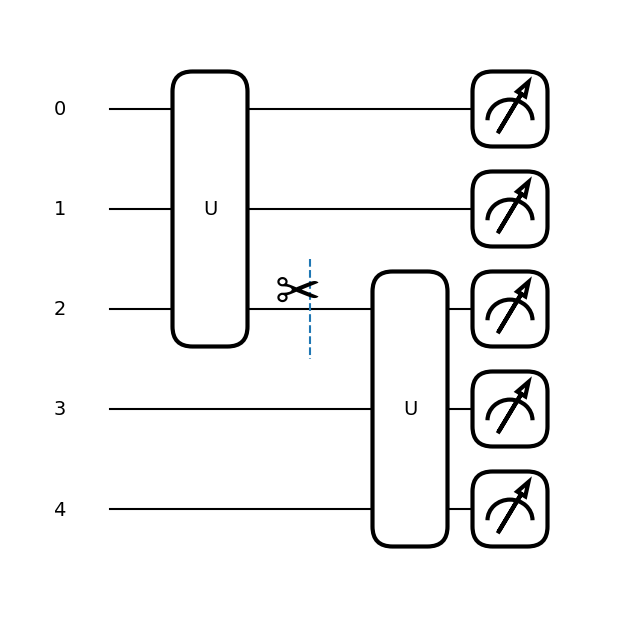

In [2]:
# from ricco.utils import (generate_random_circuit, replace_measure_with_unitary, 
#                    vqe_circuit, generate_n_qubit_unitary, ricco_string_to_pauli_word,
#                   get_upstream_subcircuit)




import pennylane as qml
from pennylane import numpy as np
num_qubits = 5
num_cuts=1
seed_u = 103
seed_v = 105

# Define RICCO parameters for unitary rotation at cut locations
# params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True)

# Initialize device for RICCO optimization
dev = qml.device("default.qubit", wires=range(num_qubits))

# Define and create a QNode for the generated quantum circuit
random_circuit_qnode = qml.QNode(generate_random_circuit, device=dev)

# Update QNode and Compute expectation value of the uncut circuit
uncut_random_circuit_expval = random_circuit_qnode(
    num_qubits, num_cuts, seed_u, seed_v, unitary_rotation=False
)

# Optionally display the uncut circuit
# if draw:
fig1, ax = qml.draw_mpl(random_circuit_qnode)(num_qubits, num_cuts, 
                                              seed_u, seed_v, 
                                              unitary_rotation=False)

tape = random_circuit_qnode.qtape
tape.operations


In [3]:
# from pennylane.qcut import MeasureNode, PrepareNode, _prep_zero_state, _prep_minus_state, _get_measurements

In [7]:
## WORKING FOR VERSION 0.28.0

# import pennylane as qml
# from pennylane.tape import QuantumTape
# from pennylane.transforms.qcut import (
#     MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
# )
# from pennylane import numpy as np
# from typing import Dict, List, Tuple
# from itertools import product


# class RICCO:
#     """
#     Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

#     This class partitions a quantum circuit into fragments, applies circuit cutting, 
#     optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
#     with their conjugate transposes.

#     Attributes:
#         circuit (qml.QNode): Original uncut quantum circuit.
#         cuts (int): Number of wire cuts (equivalent to MeasureNodes).
#         device (qml.Device): Quantum device for execution.
#         num_qubits (int): Number of qubits in the circuit.
#         params (List[np.ndarray]): Rotation parameters for each MeasureNode.
#         tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
#         tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
#         communication_graph (networkx.DiGraph): Graph representing circuit fragments.
#         prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
#         meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
#         meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
#         expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
#         upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
#         midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
#         downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
#     """

#     def __init__(self, circuit: qml.QNode, cuts: int, device):
#         """
#         Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

#         Args:
#             circuit (qml.QNode): The quantum circuit to be optimized.
#             cuts (int): The number of wire cuts (MeasureNodes).
#             device (qml.Device): The quantum device for execution.
#         """
#         self.circuit = circuit
#         self.cuts = cuts
#         self.device = device
#         self.tape = circuit.qtape  # Convert QNode to a quantum tape
#         self.num_qubits = len(self.tape.wires)

#         # Initialize differentiable rotation parameters (one per MeasureNode)
#         self.params = [
#             np.array(np.random.uniform(-np.pi, np.pi, size=3), requires_grad=True)
#             for _ in range(self.cuts)
#         ]

#         # Convert the quantum tape to a graph representation
#         self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
#         qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

#         # Generate circuit fragments and communication graph
#         frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
#         self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

#         # Create mappings between MeasureNodes and PrepareNodes
#         self.prep_to_meas_map = {
#             pred_edge["pair"][1].id: pred_edge["pair"][0].id
#             for node in self.communication_graph.nodes
#             for _, pred_edges in self.communication_graph.pred[node].items()
#             for pred_edge in pred_edges.values()
#         }
#         self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

#         # Initialize parameter mapping for unitary rotations
#         self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

#         # Initialize subcircuit attributes
#         self.expanded_tapes = []
#         self.measure_nodes = []
#         self.prepare_nodes = []
#         self.upstream_subcircuits = []
#         self.midstream_subcircuits = []
#         self.downstream_subcircuits = []

#         # Expand and classify fragments
#         self.ricco_expand_fragment_tapes()

    
#     def ricco_expand_fragment_tapes(self):
#         """
#         Expands circuit fragments, applies unitary rotations to MeasureNodes, 
#         and updates PrepareNodes with their conjugate transposes.
#         """
#         # List of predefined preparation settings
#         PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

#         expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
#         upstream, midstream, downstream = [], [], []

#         for tape in self.tape_fragments:
#             prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
#             measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
#             wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

#             for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
#                 for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
#                     measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

#                     with qml.tape.QuantumTape() as expanded_tape:
#                         for op in tape.operations:
#                             if isinstance(op, PrepareNode):
#                                 prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
#                                 prepare_fn(op.wires[0])
#                                 params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
#                                 qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
#                             elif isinstance(op, MeasureNode):
#                                 params = self.meas_to_params_map[op.id]
#                                 qml.Rot(*params, wires=op.wires[0])
#                             else:
#                                 qml.apply(op)
#                         for meas in _get_measurements(measurement_ops, tape.measurements):
#                             qml.apply(meas)
#                     expanded_tapes.append(expanded_tape)

#                     if measure_nodes and prepare_nodes:
#                         midstream.append(expanded_tape)
#                     elif measure_nodes:
#                         upstream.append(expanded_tape)
#                     else:
#                         downstream.append(expanded_tape)

#             all_measure_nodes.extend(measure_nodes)
#             all_prepare_nodes.extend(prepare_nodes)

#         self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
#         self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


#     def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.01):
#         """
#         Optimizes unitary rotation parameters in upstream and midstream subcircuits.
#         """
#         def cost_function(params):
#             self.params = params
#             self.ricco_expand_fragment_tapes()
#             expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
#             return np.sum(-np.abs(expvals))

#         params = np.array(self.params, requires_grad=True)
#         opt = qml.GradientDescentOptimizer(stepsize)
#         for step in range(steps):
#             params = opt.step(cost_function, params)
#             if step % (steps // 10) == 0:
#                 print(f"Step {step}: Cost = {cost_function(params):.6f}")

#         self.params = params
#         self.ricco_expand_fragment_tapes()
#         print("Optimization complete!")


#     def execute_subcircuits(self, subcircuits):
#         if not subcircuits:
#             raise ValueError("No subcircuits provided for execution.")
#         return np.array(qml.execute(subcircuits, self.device, gradient_fn=qml.gradients.param_shift))


In [158]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                # params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                # qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                                qml.adjoint(qml.Rot)(*self.meas_to_params_map[self.prep_to_meas_map[op.id]], wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                # params = self.meas_to_params_map[op.id]
                                # qml.Rot(*params, wires=op.wires[0])
                                qml.Rot(*self.meas_to_params_map[op.id], wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # for meas in _get_measurements(measurement_ops, tape.measurements):
                        #     qml.apply(meas)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    # def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.5, optimizer=None):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
    #     Args:
    #         steps (int): Number of optimization steps.
    #         stepsize (float): Learning rate for the optimizer.
    #         optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
    #     """
    #     if optimizer is None:
    #         optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
    #     def cost_function(params):
    #         # Ensure params are properly updated and trackable
    #         self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    #         self.ricco_expand_fragment_tapes()
    
    #         # Execute subcircuits and get expectation values
    #         expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
    #         # Apply the squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         expvals_squared = np.square(expvals)
    #         F = ones_matrix - expvals_squared
    #         cost = np.sum(F)

    #         if step % (steps // 10) == 0:
    #             # print(f"Expvals at step: {expvals}")  # Debugging
    #             print(f"Cost at step: {cost:.6f}")
    
    #         return cost  # Minimize the squared deviation
    
    #     # Convert params to a PennyLane-compatible tensor
    #     params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
    #     for step in range(steps):
    #         params = optimizer.step(cost_function, params)
    
    #         # 🔹 Debugging: Print updated parameters
    #         # print(f"Step {step}: Cost = {cost_function(params):.6f}")
    #         # print(f"Updated Params:\n{params}")
    
    #     # Assign optimized parameters back
    #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    #     self.ricco_expand_fragment_tapes()
    #     print("Optimization complete!")


    def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        def cost_function(params):
            # ✅ Properly assign self.params so it remains differentiable
            self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            self.ricco_expand_fragment_tapes()
    
            # ✅ Compute expectation values (should depend on params)
            expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
            # ✅ Apply the squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            expvals_squared = np.square(expvals)
            F = ones_matrix - expvals_squared
            cost = np.sum(F)

            if step % (steps // 10) == 0:
                # print(f"Expvals at step: {expvals}")
                print(f"Cost at step: {cost:.6f}")
    
            return cost
    
        # ✅ Ensure params is a differentiable tensor
        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
        for step in range(steps):
            params = optimizer.step(cost_function, params)
    
            # print(f"Step {step}: Cost = {cost_function(params):.6f}")
            # print(f"Updated Params:\n{params}")
    
        # ✅ Assign optimized parameters back
        self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        self.ricco_expand_fragment_tapes()
        print("Optimization complete!")






    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return np.array(qml.execute(subcircuits, self.device, gradient_fn=qml.gradients.param_shift))
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")



In [208]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                # params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                # qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                                qml.adjoint(qml.Rot)(*self.meas_to_params_map[self.prep_to_meas_map[op.id]], wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                # params = self.meas_to_params_map[op.id]
                                # qml.Rot(*params, wires=op.wires[0])
                                qml.Rot(*self.meas_to_params_map[op.id], wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # for meas in _get_measurements(measurement_ops, tape.measurements):
                        #     qml.apply(meas)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        def cost_function(params):
            # Update self.params and the mapping to ensure the circuit uses the new values
            self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            self.meas_to_params_map = {
                meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
            }
            self.ricco_expand_fragment_tapes()
        
            # Compute expectation values (should depend on updated params)
            expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
        
            if step % (steps // 10) == 0:
                # print(f"Cost at step: {cost:.6f}")
                print(f"Cost at step: {qml.math.array(cost)}")
        
            return cost

    
        # ✅ Ensure params is a differentiable tensor
        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
        for step in range(steps):
            params = optimizer.step(cost_function, params)
    
            # print(f"Step {step}: Cost = {cost_function(params):.6f}")
            # print(f"Updated Params:\n{params}")
    
        # ✅ Assign optimized parameters back
        self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        self.ricco_expand_fragment_tapes()
        print("Optimization complete!")


    # def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.5, optimizer=None):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
    #     Args:
    #         steps (int): Number of optimization steps.
    #         stepsize (float): Learning rate for the optimizer.
    #         optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
    #     """
    #     if optimizer is None:
    #         optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
    #     # def cost_function(params):
    #     #     # ✅ Properly update self.params
    #     #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    
    #     #     # ✅ Ensure meas_to_params_map is updated
    #     #     for meas_id, new_params in zip(self.meas_to_params_map.keys(), self.params):
    #     #         self.meas_to_params_map[meas_id] = new_params
    
    #     #     # ✅ Rebuild circuits with updated parameters
    #     #     self.ricco_expand_fragment_tapes()
    
    #     #     # ✅ Compute expectation values
    #     #     expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
    #     #     # ✅ Compute squared deviation cost function
    #     #     ones_matrix = np.ones_like(expvals)
    #     #     expvals_squared = np.square(expvals)
    #     #     F = ones_matrix - expvals_squared
    #     #     cost = np.sum(F)
    
    #     #     print(f"Expvals at step: {expvals}")
    #     #     print(f"Cost at step: {cost:.6f}")
    
    #     #     return cost

    #     def cost_function(params):
    #         # ✅ Properly update self.params
    #         self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        
    #         # ✅ Ensure meas_to_params_map is updated
    #         for meas_id, new_params in zip(self.meas_to_params_map.keys(), self.params):
    #             self.meas_to_params_map[meas_id] = new_params
        
    #         # ✅ Rebuild circuits with updated parameters
    #         self.ricco_expand_fragment_tapes()
        
    #         # ✅ Compute expectation values
    #         expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
        
    #         # ✅ Compute squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         expvals_squared = np.square(expvals)
    #         F = ones_matrix - expvals_squared
    #         cost = np.sum(F)
        
    #         # ✅ Convert `ArrayBox` objects to plain numbers before printing
    #         print(f"Expvals at step: {qml.numpy.array(expvals)}")
    #         print(f"Cost at step: {qml.numpy.array(cost).item():.6f}")
        
    #         return cost

    
    #     # ✅ Convert params to a differentiable tensor
    #     params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
    #     for step in range(steps):
    #         params = optimizer.step(cost_function, params)
    
    #         print(f"Step {step}: Cost = {cost_function(params):.6f}")
    #         print(f"Updated Params:\n{params}")
    
    #     # ✅ Assign optimized parameters back
    #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    #     self.ricco_expand_fragment_tapes()
    #     print("Optimization complete!")


    # def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.01):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    #     """
    
    #     def cost_function(params):
    #         # ✅ Ensure self.params is updated
    #         self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    
    #         # ✅ Ensure self.meas_to_params_map is updated at each step
    #         for meas_id, new_params in zip(self.meas_to_params_map.keys(), self.params):
    #             self.meas_to_params_map[meas_id] = new_params
    
    #         # ✅ Rebuild circuits with updated parameters
    #         self.ricco_expand_fragment_tapes()
    
    #         # ✅ Compute expectation values
    #         expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
    #         # ✅ Compute squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         expvals_squared = np.square(expvals)
    #         F = ones_matrix - expvals_squared
    #         cost = np.sum(F)
    
    #         # ✅ Convert `ArrayBox` objects to plain numbers before printing
    #         expvals_np = qml.numpy.array(expvals)
    #         cost_np = qml.numpy.array(cost).item()  # 🚀 Fix: Ensure cost is a regular float

    
    #         print(f"Expvals at step: {expvals_np}")
    #         print(f"Cost at step: {cost_np:.6f}")  # 🚀 Fix: Correct formatting
    
    #         return cost
    
    #     # ✅ Ensure params are properly initialized
    #     params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
    #     # ✅ Initialize the optimizer
    #     optimizer = qml.GradientDescentOptimizer(stepsize)
    
    #     for step in range(steps):
    #         params = optimizer.step(cost_function, params)
    
    #         print(f"Step {step}: Cost = {cost_function(params):.6f}")
    #         print(f"Updated Params:\n{params}")
    
    #     # ✅ Finalize the parameter update
    #     self.params = params
    #     self.ricco_expand_fragment_tapes()
    #     print("Optimization complete!")


    # def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.01):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    #     """
    
    #     def cost_function(params):
    #         # ✅ Ensure self.params is updated
    #         self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
    
    #         # ✅ Ensure self.meas_to_params_map is updated at each step
    #         for meas_id, new_params in zip(self.meas_to_params_map.keys(), self.params):
    #             self.meas_to_params_map[meas_id] = new_params
    
    #         # ✅ Rebuild circuits with updated parameters
    #         self.ricco_expand_fragment_tapes()
    
    #         # ✅ Compute expectation values
    #         expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
    #         # ✅ Compute squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         expvals_squared = np.square(expvals)
    #         F = ones_matrix - expvals_squared
    #         cost = np.sum(F)
    
    #         # ✅ Convert `ArrayBox` to regular numpy type before printing
    #         expvals_np = qml.numpy.array(expvals)
    #         cost_np = qml.numpy.array(cost).astype(float)  # 🔥 FIX: Convert to a standard float type
    
    #         print(f"Expvals at step: {expvals_np}")
    #         print(f"Cost at step: {cost_np:.6f}")  # ✅ FIXED: Now it's a proper float
    
    #         return cost
    
    #     # ✅ Ensure params are properly initialized
    #     params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
    #     # ✅ Initialize the optimizer
    #     optimizer = qml.GradientDescentOptimizer(stepsize)
    
    #     for step in range(steps):
    #         params = optimizer.step(cost_function, params)
    
    #         cost_value = cost_function(params)  # 🔥 Call `cost_function` directly
    #         print(f"Step {step}: Cost = {qml.numpy.array(cost_value).astype(float):.6f}")  # ✅ FIXED
    
    #     # ✅ Finalize the parameter update
    #     self.params = params
    #     self.ricco_expand_fragment_tapes()
    #     print("Optimization complete!")


    # def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.01):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    #     Uses a squared deviation cost function to improve circuit performance.
    #     """
    
    #     def cost_function(params):
    #         # ✅ Ensure `self.params` is updated properly
    #         self.params = params.reshape(self.cuts, 3)  
    
    #         # ✅ Update `meas_to_params_map` so circuits see updated parameters
    #         for meas_id, new_params in zip(self.meas_to_params_map.keys(), self.params):
    #             self.meas_to_params_map[meas_id] = new_params
    
    #         # ✅ Rebuild circuits with updated parameters
    #         self.ricco_expand_fragment_tapes()
    
    #         # ✅ Compute expectation values
    #         expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
    #         # ✅ Compute squared deviation cost function
    #         ones_matrix = qml.numpy.ones_like(expvals)
    #         expvals_squared = qml.numpy.square(expvals)
    #         F = ones_matrix - expvals_squared
    #         cost = qml.numpy.sum(F)  # ✅ Ensure `cost` is a scalar
    
    #         # ✅ Convert `cost` and `expvals` to standard float for printing
    #         expvals_np = qml.math.toarray(expvals)
    #         cost_np = qml.math.toarray(cost)  # 🔥 FIX: Ensure cost is a scalar
    
    #         print(f"Expvals at step: {expvals_np}")
    #         # print(f"Cost at step: {cost_np:.6f}")  # ✅ FIXED
    #         print(f"Cost at step: {cost_np}")  # ✅ FIXED
    
    #         return cost
    
    #     # ✅ Ensure params are properly initialized
    #     params = qml.numpy.array(self.params.flatten(), requires_grad=True)
    
    #     # ✅ Initialize the optimizer
    #     optimizer = qml.GradientDescentOptimizer(stepsize)
    
    #     for step in range(steps):
    #         params = optimizer.step(cost_function, params)
    
    #         # ✅ Call `cost_function` explicitly to print updates
    #         cost_value = cost_function(params)
    
    #         print(f"Step {step}: Cost = {float(cost_value):.6f}")  # ✅ FIXED
    
    #     # ✅ Finalize the parameter update
    #     self.params = params.reshape(self.cuts, 3)
    #     self.ricco_expand_fragment_tapes()
    #     print("Optimization complete!")










    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return np.array(qml.execute(subcircuits, self.device, gradient_fn=qml.gradients.param_shift))
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")



In [82]:
# # Convert the uncut QNode to a quantum tape for processing
# tape = random_circuit_qnode.qtape

# # Perform circuit cutting on the quantum tape
# graph = qml.qcut.tape_to_graph(tape)
# qml.qcut.replace_wire_cut_nodes(graph)

# # Generate fragments and the communication graph for circuit cutting
# fragments, communication_graph = qml.qcut.fragment_graph(graph)
# fragment_tapes = [qml.qcut.graph_to_tape(f) for f in fragments]

In [211]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params) == qml._grad.ArrayBox:
                                    params = qml.math.toarray(params)
                                else:
                                    params.requires_grad = False
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        def cost_function(params):
            # Update self.params and the mapping to ensure the circuit uses the new values
            self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            self.meas_to_params_map = {
                meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
            }
            self.ricco_expand_fragment_tapes()
        
            # Compute expectation values (should depend on updated params)
            expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
        
            if step % (steps // 10) == 0:
                # print(f"Cost at step: {cost:.6f}")
                print(f"Cost at step: {qml.math.toarray(cost)}")
        
            return cost

    
        # ✅ Ensure params is a differentiable tensor
        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
        for step in range(steps):
            params = optimizer.step(cost_function, params)
    
            # print(f"Step {step}: Cost = {cost_function(params):.6f}")
            # print(f"Updated Params:\n{params}")
    
        # ✅ Assign optimized parameters back
        self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        self.ricco_expand_fragment_tapes()
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return np.array(qml.execute(subcircuits, self.device, gradient_fn=qml.gradients.param_shift))
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")



In [257]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.
    [Documentation omitted for brevity]
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = qml.numpy.tensor(
            np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)),
            requires_grad=True
        )

        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        print(f"[DEBUG] Initialized with {len(self.tape_fragments)} tape fragments.")

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {
            meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        }

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        print("[DEBUG] Expanding fragment tapes...")
        for idx, tape in enumerate(self.tape_fragments):
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            print(f"[DEBUG] Tape {idx}: {len(prepare_nodes)} PrepareNodes, {len(measure_nodes)} MeasureNodes.")

            # Use product over preparation settings for each PrepareNode in the tape
            for prep_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                # When there are measure nodes, get a partition (otherwise use a dummy grouping)
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prep_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                # Apply the adjoint of Rot with the shared parameter from mapping
                                params_used = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params_used) == qml._grad.ArrayBox:
                                    params_used = qml.math.toarray(params_used)
                                    # params_used.requires_grad = False
                                else:
                                    params_used.requires_grad = False
                                qml.adjoint(qml.Rot)(*params_used, wires=op.wires[0])
                                print(f"[DEBUG] PrepareNode on wire {op.wires[0]} using params {params_used}.")
                            elif isinstance(op, MeasureNode):
                                params_used = self.meas_to_params_map[op.id]
                                qml.Rot(*params_used, wires=op.wires[0])
                                print(f"[DEBUG] MeasureNode on wire {op.wires[0]} using params {params_used}.")
                            else:
                                qml.apply(op)
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes = expanded_tapes
        self.measure_nodes = all_measure_nodes
        self.prepare_nodes = all_prepare_nodes
        self.upstream_subcircuits = upstream
        self.midstream_subcircuits = midstream
        self.downstream_subcircuits = downstream

        print(f"[DEBUG] Total expanded tapes: {len(self.expanded_tapes)}")
        print(f"[DEBUG] Upstream subcircuits: {len(self.upstream_subcircuits)}")
        print(f"[DEBUG] Midstream subcircuits: {len(self.midstream_subcircuits)}")
        print(f"[DEBUG] Downstream subcircuits: {len(self.downstream_subcircuits)}")

    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.01, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream subcircuits.
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

        def cost_function(params):
            # Reshape and update parameters
            self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            self.meas_to_params_map = {
                meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
            }
            print(f"[DEBUG] Cost function called with params:\n{self.params}")
            self.ricco_expand_fragment_tapes()

            # Execute only upstream subcircuits for optimization
            expvals = self.execute_subcircuits(self.upstream_subcircuits)
            print(f"[DEBUG] Expectation values: {expvals}")

            # Compute cost as squared deviation
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            return cost

        # Ensure params is a differentiable tensor
        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)

        for step in range(steps):
            params = optimizer.step(cost_function, params)
            # Optionally, print cost every few steps
            if step % (steps // 2) == 0:
                current_cost = cost_function(params)
                print(f"[DEBUG] Step {step}: Cost = {current_cost}")
                print(f"[DEBUG] Updated Params:\n{params}")

        # Update the optimized parameters back into the object
        self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        self.ricco_expand_fragment_tapes()
        print("[DEBUG] Optimization complete!")
        print(f"[DEBUG] Final parameters:\n{self.params}")

    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        print(f"[DEBUG] Executing {len(subcircuits)} subcircuits...")
        # Use parameter-shift differentiation; you can swap diff_method if needed
        results = qml.execute(subcircuits, self.device, diff_method="parameter-shift")
        print(f"[DEBUG] Execution results: {results}")
        return results


In [272]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from itertools import product

class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.
    [Documentation omitted for brevity]
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = qml.numpy.tensor(
            np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)),
            requires_grad=True
        )

        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        print(f"[DEBUG] Initialized with {len(self.tape_fragments)} tape fragments.")

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {
            meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        }

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    def ricco_expand_fragment_tapes(self):
        """
        Expands all fragments (upstream, midstream, downstream) using the current parameters.
        """
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        print("[DEBUG] Expanding fragment tapes...")
        for idx, tape in enumerate(self.tape_fragments):
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            print(f"[DEBUG] Tape {idx}: {len(prepare_nodes)} PrepareNodes, {len(measure_nodes)} MeasureNodes.")

            # For each possible preparation setting (if any)
            for prep_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                # When there are measure nodes, get a partition (otherwise use a dummy grouping)
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prep_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                qml.adjoint(qml.Rot)(
                                    *self.meas_to_params_map[self.prep_to_meas_map[op.id]], wires=op.wires[0]
                                )
                                print(f"[DEBUG] PrepareNode on wire {op.wires[0]} using params {self.meas_to_params_map[self.prep_to_meas_map[op.id]]}.")
                            elif isinstance(op, MeasureNode):
                                qml.Rot(*self.meas_to_params_map[op.id], wires=op.wires[0])
                                print(f"[DEBUG] MeasureNode on wire {op.wires[0]} using params {self.meas_to_params_map[op.id]}.")
                            else:
                                qml.apply(op)
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes = expanded_tapes
        self.measure_nodes = all_measure_nodes
        self.prepare_nodes = all_prepare_nodes
        self.upstream_subcircuits = upstream
        self.midstream_subcircuits = midstream
        self.downstream_subcircuits = downstream

        print(f"[DEBUG] Total expanded tapes: {len(self.expanded_tapes)}")
        print(f"[DEBUG] Upstream subcircuits: {len(self.upstream_subcircuits)}")
        print(f"[DEBUG] Midstream subcircuits: {len(self.midstream_subcircuits)}")
        print(f"[DEBUG] Downstream subcircuits: {len(self.downstream_subcircuits)}")

    def ricco_expand_upstream_fragment_tapes(self):
        """
        Debug method: expands and updates only the upstream subcircuits—that is, those tapes
        that contain MeasureNodes and no PrepareNodes—with the current parameters.
        """
        expanded_upstream = []
        # We still need PREPARE_SETTINGS for consistency, but tapes with PrepareNodes will be skipped.
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        print("[DEBUG] Expanding only upstream fragment tapes...")
        for idx, tape in enumerate(self.tape_fragments):
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            # Only proceed if this tape has measure nodes and NO prepare nodes (upstream)
            if measure_nodes and not prepare_nodes:
                wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
                # Since there are no prepare nodes, product(range(...), repeat=0) yields one tuple: ()
                for _ in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                    for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0]:
                        measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)]
                        with qml.tape.QuantumTape() as expanded_tape:
                            for op in tape.operations:
                                if isinstance(op, MeasureNode):
                                    qml.Rot(*self.meas_to_params_map[op.id], wires=op.wires[0])
                                    print(f"[DEBUG] (Upstream) MeasureNode on wire {op.wires[0]} using params {self.meas_to_params_map[op.id]}.")
                                else:
                                    qml.apply(op)
                            with qml.QueuingManager.stop_recording():
                                measurements = _get_measurements(measurement_ops, tape.measurements)
                            for meas in measurements:
                                qml.apply(meas)
                        expanded_upstream.append(expanded_tape)
            else:
                print(f"[DEBUG] Tape {idx} skipped (not upstream; {len(prepare_nodes)} PrepareNodes found).")

        self.upstream_subcircuits = expanded_upstream
        print(f"[DEBUG] Updated upstream subcircuits: {len(self.upstream_subcircuits)}")

    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters using only the upstream subcircuits.
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)

        def cost_function(params):
            self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            self.meas_to_params_map = {
                meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
            }
            print(f"[DEBUG] Cost function called with params:\n{self.params}")
            # Instead of expanding all tapes, update only the upstream ones.
            self.ricco_expand_upstream_fragment_tapes()

            # Execute only the upstream subcircuits for cost evaluation.
            expvals = self.execute_subcircuits(self.upstream_subcircuits)
            print(f"[DEBUG] Upstream expectation values: {expvals}")

            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
            return cost

        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)

        for step in range(steps):
            params = optimizer.step(cost_function, params)
            if step % (steps // 2) == 0:
                current_cost = cost_function(params)
                print(f"[DEBUG] Step {step}: Cost = {current_cost}")
                print(f"[DEBUG] Updated Params:\n{params}")

        self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        self.ricco_expand_upstream_fragment_tapes()
        print("[DEBUG] Optimization complete!")
        print(f"[DEBUG] Final parameters:\n{self.params}")

    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        print(f"[DEBUG] Executing {len(subcircuits)} subcircuits...")
        results = qml.execute(subcircuits, self.device, diff_method="parameter-shift")
        print(f"[DEBUG] Execution results: {results}")
        return results


In [285]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape
        self.num_qubits = len(self.tape.wires)

        # ✅ Store params as a **single** trainable array
        self.params = qml.numpy.array(
            np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), requires_grad=True
        )

        # Convert to graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)

        # Generate circuit fragments
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()


    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.params[self.prep_to_meas_map[op.id]]
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.params[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)

                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)

                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def expand_and_update_upstream_subcircuits(self):
        """
        Expands and updates only the upstream subcircuits during optimization.

        This method will be used as a debugging tool to check if optimization
        is working properly when applied **only** to upstream subcircuits.
        """
        expanded_tapes = []

        for tape in self.upstream_subcircuits:
            with qml.tape.QuantumTape() as expanded_tape:
                for op in tape.operations:
                    if isinstance(op, MeasureNode):
                        params = self.params[op.id]
                        qml.Rot(*params, wires=op.wires[0])
                    else:
                        qml.apply(op)

                # Preserve measurements
                for meas in tape.measurements:
                    qml.apply(meas)

            expanded_tapes.append(expanded_tape)

        self.upstream_subcircuits = expanded_tapes  # Update the upstream subcircuits


    def optimize_upstream_rotations(self, steps: int = 100, stepsize: float = 0.01):
        """
        Optimizes only the unitary rotations in the upstream subcircuits.

        This is a **debugging** method to test whether optimization works
        correctly when applied only to upstream subcircuits.
        """

        def cost_function(params):
            self.params = params  # 🔥 Ensure self.params updates
            self.expand_and_update_upstream_subcircuits()  # 🔥 Expand only upstream

            expvals = self.execute_subcircuits(self.upstream_subcircuits)

            # ✅ Compute cost
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            # ✅ Convert to regular numpy type for printing
            expvals_np = qml.math.toarray(expvals)
            cost_np = qml.math.toarray(cost).item()

            print(f"Expvals at step: {expvals_np}")
            print(f"Cost at step: {cost_np:.6f}")

            return cost

        # ✅ Store params as a **trainable** NumPy array
        params = qml.numpy.array(self.params.copy(), requires_grad=True)
        optimizer = qml.GradientDescentOptimizer(stepsize)

        for step in range(steps):
            params, cost_value = optimizer.step_and_cost(cost_function, params)

            # ✅ Convert cost to standard float for printing
            cost_value = qml.math.toarray(cost_value).item()

            print(f"Step {step}: Cost = {cost_value:.6f}")
            print(f"Updated Params:\n{qml.math.toarray(params)}")

        self.params = params  # ✅ Final update
        self.expand_and_update_upstream_subcircuits()
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        """
        Executes a list of subcircuits and returns expectation values.

        Args:
            subcircuits (List[qml.tape.QuantumTape]): The subcircuits to execute.

        Returns:
            np.ndarray: Expectation values from circuit executions.
        """
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        
        # ✅ Ensure execution returns an array (not ArrayBox)
        return qml.math.toarray(qml.execute(subcircuits, self.device, diff_method=qml.gradients.param_shift))


In [322]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape
        self.num_qubits = len(self.tape.wires)

        # ✅ Store params as a **single** trainable array with correct indexing
        self.params = qml.numpy.tensor(
            np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), requires_grad=True
        )

        # Convert to graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)

        # Generate circuit fragments
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {}
        self.meas_to_prep_map = {}
        self.meas_to_index = {}  # ✅ Map MeasureNode IDs to a sequential index

        index = 0
        for node in self.communication_graph.nodes:
            for _, pred_edges in self.communication_graph.pred[node].items():
                for pred_edge in pred_edges.values():
                    prep_id = pred_edge["pair"][1].obj.id
                    meas_id = pred_edge["pair"][0].obj.id
                    self.prep_to_meas_map[prep_id] = meas_id
                    self.meas_to_prep_map[meas_id] = prep_id
                    if meas_id not in self.meas_to_index:
                        self.meas_to_index[meas_id] = index
                        index += 1

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Expand and classify fragments
        self.ricco_expand_fragment_tapes()

    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                meas_id = self.prep_to_meas_map[op.id]
                                params = self.params[self.meas_to_index[meas_id]]
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.params[self.meas_to_index[op.id]]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)

                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)

                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def expand_and_update_upstream_subcircuits(self, tmp_params):
        """
        Expands **only the upstream subcircuits** using the latest `self.params`,
        ensuring that the unitary rotations replacing MeasureNodes are up to date.
        """
        updated_upstream = []
        # self.params = tmp_params

        for tape in self.upstream_subcircuits:
            with qml.tape.QuantumTape() as updated_tape:
                for op in tape.operations:
                    if isinstance(op, MeasureNode):
                        params = tmp_params[self.meas_to_index[op.id]]
                        qml.Rot(*params, wires=op.wires[0])
                    else:
                        qml.apply(op)

                for meas in tape.measurements:
                    qml.apply(meas)

            updated_upstream.append(updated_tape)

        # self.upstream_subcircuits = updated_upstream
        return updated_upstream

    def optimize_upstream_rotations(self, steps: int = 10, stepsize: float = 0.01):
        """
        Optimizes **only the unitary rotations in upstream subcircuits**.

        This helps verify whether optimization is properly affecting the circuit.

        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate.
        """
        optimizer = qml.AdamOptimizer(stepsize)

        def cost_function(params):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            update_upstream_subcircuits = self.expand_and_update_upstream_subcircuits(params)

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)

            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            print(f"Cost at step: {qml.math.toarray(cost)}")
            return cost

        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)

        for step in range(steps):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            # self.expand_and_update_upstream_subcircuits(params)
            params = optimizer.step(cost_function, params)

        # ✅ Assign optimized parameters back
        # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        # self.expand_and_update_upstream_subcircuits(params)
        print("Optimization of upstream rotations complete!")

    def execute_subcircuits(self, subcircuits):
        """
        Executes a list of subcircuits and returns expectation values.

        Args:
            subcircuits (List[qml.tape.QuantumTape]): The subcircuits to execute.

        Returns:
            np.ndarray: Expectation values from circuit executions.
        """
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")


In [527]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params) == qml._grad.ArrayBox:
                                    params = qml.math.toarray(params)
                                else:
                                    params.requires_grad = False
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def expand_and_update_upstream_subcircuits(self, params):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
        meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), params)}

        for tape in self.upstream_subcircuits:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            # if isinstance(op, PrepareNode):
                            #     prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            #     prepare_fn(op.wires[0])
                            #     params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                            #     if type(params) == qml._grad.ArrayBox:
                            #         params = qml.math.toarray(params)
                            #     else:
                            #         params.requires_grad = False
                            #     qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            # elif isinstance(op, MeasureNode):
                            if isinstance(op, MeasureNode):
                                param = meas_to_params_map[op.id]
                                qml.Rot(*param, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        # self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        # self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream
        return upstream


    


    def _apply_rotation_and_update_measurement(self, subcircuit: qml.tape.QuantumTape, wire: int, params: np.ndarray):
        """
        Replaces the MeasureNode in the given subcircuit with a unitary rotation and updates measurements.
    
        Args:
            subcircuit (qml.tape.QuantumTape): The quantum subcircuit containing the MeasureNode.
            wire (int): The qubit wire where the MeasureNode is located.
            params (np.ndarray): The unitary rotation parameters (θ, φ, λ).
        """
        theta, phi, lam = params
        new_observables = []  # List to hold updated measurement observables
    
        with qml.tape.QuantumTape() as modified_tape:
            for op in subcircuit.operations:
                if isinstance(op, MeasureNode) and wire in op.wires:
                    qml.Rot(theta, phi, lam, wires=wire)  # Apply unitary rotation
                else:
                    qml.apply(op)
    
            # Convert existing measurement observables to string format
            wire_map = {w: i for i, w in enumerate(subcircuit.wires)}
    
            for meas in subcircuit.measurements:
                obs = meas.obs  # Extract observable
                
                # Convert observable to a string representation
                # obs_str, obs_wires = qml.grouping.pauli_word_to_string(obs)
                obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
                obs_wires = subcircuit.wires

                # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
                d = {w: p for w, p in list(zip(obs_wires, obs_str))}
                new_obs_list = []
                for ob in ["I", "Z"]: # Replace with I and Z
                    d[wire] = ob
                    ob_tmp = ""
                    for v in d.values():
                        ob_tmp += v  # Keep the same observable
                    new_obs_list.append(ob_tmp)
    
                # Generate new observables using `ricco_string_to_pauli_word`
                for obs_variant in new_obs_list:  # Combine I/Z with existing observables
                    observable = ricco_string_to_pauli_word(
                        obs_variant,
                        wire_map=wire_map
                    )
                    qml.expval(observable)  # Apply updated expectation value


    def replace_measure_with_unitary(self,
    subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        for subcircuit in subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())
    
        return new_tape


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        # def cost_function(params):
        #     # Update self.params and the mapping to ensure the circuit uses the new values
        #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        #     self.meas_to_params_map = {
        #         meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        #     }
        #     self.ricco_expand_fragment_tapes()
        
        #     # Compute expectation values (should depend on updated params)
        #     expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
        #     # Squared deviation cost function
        #     ones_matrix = np.ones_like(expvals)
        #     cost = np.sum(ones_matrix - np.square(expvals))
        
        #     if step % (steps // 10) == 0:
        #         # print(f"Cost at step: {cost:.6f}")
        #         print(f"Cost at step: {qml.math.toarray(cost)}")
        
        #     return cost


        def cost_function(params):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.upstream_subcircuits, params)
            
            # self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]
            update_upstream_subcircuits = self.replace_measure_with_unitary(self.tape_fragments, params)
            # for circ in update_upstream_subcircuits:
            # print(update_upstream_subcircuits.draw())
            # print(np.array(qml.execute([update_upstream_subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]))

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)

            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            # print(f"Cost at step: {qml.math.toarray(cost)}")
            return cost
        

    
        # # ✅ Ensure params is a differentiable tensor
        params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True)
    
        # for step in range(steps):
        #     params, _ = optimizer.step_and_cost(cost_function, params)
    
        #     print(f"Step {step}: Cost = {cost_function(params):.6f}")
        #     # print(f"Updated Params:\n{params}")
    
        # # ✅ Assign optimized parameters back
        # # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        # # self.ricco_expand_fragment_tapes()
        # Optimization setup
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-6  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print("cost = ", prev_cost)
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return qml.math.array(qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0])
        # return np.array(qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0])
        return qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]



In [565]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params) == qml._grad.ArrayBox:
                                    params = qml.math.toarray(params)
                                else:
                                    params.requires_grad = False
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def expand_and_update_upstream_subcircuits(self, params):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
        meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), params)}

        for tape in self.upstream_subcircuits:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            # if isinstance(op, PrepareNode):
                            #     prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            #     prepare_fn(op.wires[0])
                            #     params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                            #     if type(params) == qml._grad.ArrayBox:
                            #         params = qml.math.toarray(params)
                            #     else:
                            #         params.requires_grad = False
                            #     qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            # elif isinstance(op, MeasureNode):
                            if isinstance(op, MeasureNode):
                                param = meas_to_params_map[op.id]
                                qml.Rot(*param, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        # self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        # self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream
        return upstream


    


    
    def replace_measure_with_unitary(self,
    subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        for subcircuit in subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())
    
        return new_tape


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        # def cost_function(params):
        #     # Update self.params and the mapping to ensure the circuit uses the new values
        #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        #     self.meas_to_params_map = {
        #         meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        #     }
        #     self.ricco_expand_fragment_tapes()
        
        #     # Compute expectation values (should depend on updated params)
        #     expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
        #     # Squared deviation cost function
        #     ones_matrix = np.ones_like(expvals)
        #     cost = np.sum(ones_matrix - np.square(expvals))
        
        #     if step % (steps // 10) == 0:
        #         # print(f"Cost at step: {cost:.6f}")
        #         print(f"Cost at step: {qml.math.toarray(cost)}")
        
        #     return cost


        def cost_function(params):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.upstream_subcircuits, params)
            
            # self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.tape_fragments, params)
            update_upstream_subcircuits = self.replace_measure_with_unitary(self.upstream_subcircuits + self.midstream_subcircuits,
                                                                            params)
            # update_upstream_subcircuits = self.expand_and_update_upstream_subcircuits(params)
            
            # for circ in update_upstream_subcircuits:
            # print(update_upstream_subcircuits.draw())
            # print(np.array(qml.execute([update_upstream_subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]))

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)

            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            # print(f"Cost at step: {qml.math.toarray(cost)}")
            return cost
        

    
        # # ✅ Ensure params is a differentiable tensor
        # params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True)
        params = qml.numpy.tensor(self.params.copy(), requires_grad=True)[0]
    
        # for step in range(steps):
        #     params, _ = optimizer.step_and_cost(cost_function, params)
    
        #     print(f"Step {step}: Cost = {cost_function(params):.6f}")
        #     # print(f"Updated Params:\n{params}")
    
        # # ✅ Assign optimized parameters back
        # # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        # # self.ricco_expand_fragment_tapes()
        # Optimization setup
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-6  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print("cost = ", prev_cost)
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return qml.math.array(qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0])
        # return np.array(qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0])
        # return qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]
        return qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0]
        # return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]



In [595]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params) == qml._grad.ArrayBox:
                                    params = qml.math.toarray(params)
                                else:
                                    params.requires_grad = False
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    


    


    
    def replace_measure_with_unitary(self,
    subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        for subcircuit in subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())
    
        return new_tape


    def expand_and_update_upstream_subcircuits(self, params):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
        meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), params)}

        for tape in self.upstream_subcircuits:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            # if isinstance(op, PrepareNode):
                            #     prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            #     prepare_fn(op.wires[0])
                            #     params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                            #     if type(params) == qml._grad.ArrayBox:
                            #         params = qml.math.toarray(params)
                            #     else:
                            #         params.requires_grad = False
                            #     qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            # elif isinstance(op, MeasureNode):
                            if isinstance(op, MeasureNode):
                                param = meas_to_params_map[op.id]
                                print("param = ", param)
                                qml.Rot(*param, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        # self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        # self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream
        return upstream


    def replace_measure_with_unitary(self,
    # subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        # for subcircuit in subcircuits:
        for subcircuit in self.upstream_subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = self.upstream_subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())
    
        return new_tape


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        # def cost_function(params):
        #     # Update self.params and the mapping to ensure the circuit uses the new values
        #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        #     self.meas_to_params_map = {
        #         meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        #     }
        #     self.ricco_expand_fragment_tapes()
        
        #     # Compute expectation values (should depend on updated params)
        #     expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
        #     # Squared deviation cost function
        #     ones_matrix = np.ones_like(expvals)
        #     cost = np.sum(ones_matrix - np.square(expvals))
        
        #     if step % (steps // 10) == 0:
        #         # print(f"Cost at step: {cost:.6f}")
        #         print(f"Cost at step: {qml.math.toarray(cost)}")
        
        #     return cost


        def cost_function(params):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            update_upstream_subcircuits = self.replace_measure_with_unitary(params)
            
            # self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.tape_fragments, params)
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.upstream_subcircuits + self.midstream_subcircuits,
            #                                                                 params)
            # update_upstream_subcircuits = self.expand_and_update_upstream_subcircuits(params)
            
            # for circ in update_upstream_subcircuits:
            # print(update_upstream_subcircuits.draw())
            # print(np.array(qml.execute([update_upstream_subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]))
            # print(qml.execute(update_upstream_subcircuits, self.device, gradient_fn=qml.gradients.param_shift))
            # print(np.array(qml.execute(update_upstream_subcircuits, self.device, gradient_fn=qml.gradients.param_shift)))

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)

            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            # print(f"Cost at step: {qml.math.toarray(cost)}")
            return cost
        

    
        # # ✅ Ensure params is a differentiable tensor
        params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True)
        # params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
        # for step in range(steps):
        #     params, _ = optimizer.step_and_cost(cost_function, params)
    
        #     print(f"Step {step}: Cost = {cost_function(params):.6f}")
        #     # print(f"Updated Params:\n{params}")
    
        # # ✅ Assign optimized parameters back
        # # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        # # self.ricco_expand_fragment_tapes()
        # Optimization setup
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-6  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print("cost = ", prev_cost)
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return qml.math.array(qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0])
        # return np.array(qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0])
        # return qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]
        return qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0]
        # return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]



In [720]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        # self.params = np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3), requires_grad=True)
        self.params = qml.numpy.tensor(np.random.uniform(-np.pi, np.pi, size=(self.cuts, 3)), 
                                        requires_grad=True)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    
    def ricco_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                if type(params) == qml._grad.ArrayBox:
                                    params = qml.math.toarray(params)
                                else:
                                    params.requires_grad = False
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    


    


    
    def replace_measure_with_unitary(self,
    subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        for subcircuit in subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())
    
        return new_tape


    def expand_and_update_upstream_subcircuits(self, params):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
        # meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), params)}

        for indx, tape in enumerate(self.upstream_subcircuits):
        # for tape in self.downstream_subcircuits:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
            if measure_nodes: 
                measure_combinations = qml.pauli.partition_pauli_group(len(measure_nodes))[0]
            else:
                measure_combinations = [[""]]

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in measure_combinations:                     
                    if measure_nodes:
                        measurement_ops = [qml.pauli.string_to_pauli_word(paulis, wire_map=wire_map) 
                                           for paulis in [measure_group]]
                        
                    else:
                        measurement_ops = []
                        prepare_mapping = {n: PREPARE_SETTINGS[s] for n, s in 
                                           zip(prepare_nodes, prepare_settings)}

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                # print("yes")
                                w = op.wires[0]
                                prepare_mapping[op](w)
                                # param = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                param = params[indx]
                                if type(param) == qml._grad.ArrayBox:
                                    param = qml.math.toarray(param)
                                else:
                                    param.requires_grad = False
                                qml.adjoint(qml.Rot)(*param, wires=op.wires[0])
                            elif isinstance(op, MeasureNode):
                                # param = meas_to_params_map[op.id]
                                param = params[indx]
                                # print("param = ", param)
                                qml.Rot(*param, wires=op.wires[0])
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)

                        # for meas in tape.measurements:
                        #     # print("I am new")
                        #     qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes and not prepare_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        # self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        # self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream
        return upstream
        # return downstream
        # return midstream


    def replace_measure_with_unitary(self,
    # subcircuits: List[qml.tape.QuantumScript],
    params,
) -> QuantumTape:
        """
        Replaces MeasureNodes on cut qubits in the subcircuit containing MeasureNodes with
        a unitary rotation, and updates the measurements to be expectation values of the new observables.
    
        Args:
            subcircuits (List[QuantumScript]): List of subcircuits resulting from the circuit cut.
            params: Parameters for the unitary rotation on the cut qubits.
            generate_unitary (callable): Function to generate a unitary rotation, given params and qubit labels.
    
        Returns:
            QuantumTape: A new quantum tape with the unitary rotation applied to the cut qubits
                         in place of the MeasureNodes, and with updated measurement observables.
    
        Raises:
            ValueError: If neither subcircuit contains any MeasureNodes.
        """
        # print("subcircuits[0].measurements = ", subcircuits[0].measurements[0])
        # Identify the subcircuit that contains MeasureNodes
        subcircuit_with_measure = None
        # for subcircuit in subcircuits:
        for subcircuit in self.upstream_subcircuits:
            # print(subcircuit.operations)
            # print(any(isinstance(op, qml.transforms.qcut.MeasureNode) for op in subcircuit.operations))
            # print()
            if any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
                subcircuit_with_measure = subcircuit.copy()
                # print(subcircuit.operations)
                # print("I am here")
                break
    
        # print(subcircuit_with_measure.operations)
        # Raise an error if no subcircuit with MeasureNodes is found
        if subcircuit_with_measure is None:
            raise ValueError("No subcircuit contains MeasureNodes.")
    
        # Identify the other subcircuit (assumes exactly two subcircuits)
        # subcircuit_other = subcircuits[1] if subcircuits[0] is subcircuit_with_measure else subcircuits[0]
    
        # Identify the cut qubits (common qubits between the two subcircuits)
        # cut_qubits = list(set(subcircuit_with_measure.wires) & set(subcircuit_other.wires))
        
        
        cut_qubits = [op.wires for op in subcircuit.operations if isinstance(op, qml.qcut.MeasureNode)]
        # print("cut_qubits = ", cut_qubits[0][0])
    
        # Determine number of cut and uncut qubits
        num_uncut_qubits = len(subcircuit_with_measure.wires) - len(cut_qubits)
        num_cut_qubits = len(cut_qubits)
        # print("num_cut_qubits = ", num_cut_qubits)
        
        
    
        # Generate new observables for measurement
        # new_observables = generate_observables(num_uncut_qubits, num_cut_qubits)

        obs = self.upstream_subcircuits[0].measurements[0].obs
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit.wires)
        obs_wires = subcircuit.wires

        # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
        d = {w: p for w, p in list(zip(obs_wires, obs_str))}
        new_observables = []
        for ob in ["I", "Z"]: # Replace with I and Z
            d[cut_qubits[0][0]] = ob
            ob_tmp = ""
            for v in d.values():
                ob_tmp += v  # Keep the same observable
            new_observables.append(ob_tmp)
    
        # Create a new QuantumTape to hold the modified operations
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                # if isinstance(op, qml.qcut.MeasureNode) and op.wires[0] in cut_qubits:
                if isinstance(op, qml.qcut.MeasureNode):
                    # Replace MeasureNode with the unitary rotation on the cut qubit
                    # qml.apply(generate_unitary(params, cut_qubits))
                    qml.Rot(*params, wires=op.wires)
                elif not isinstance(op, qml.qcut.MeasureNode):
                    # Apply the operation as it is if it's not a MeasureNode on a cut qubit
                    qml.apply(op)
            # print("new_observables = ", new_observables)
            # Add expectation values for each new observable to ensure measurements are defined
            for obs_str in new_observables:
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map={w: i for i, w in 
                                                                               enumerate(subcircuit_with_measure.wires)})
                qml.expval(observable)

        # print(new_tape.draw())

        # self.upstream_subcircuits = [new_tape]
    
        return new_tape


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
    
        # def cost_function(params):
        #     # Update self.params and the mapping to ensure the circuit uses the new values
        #     self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        #     self.meas_to_params_map = {
        #         meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)
        #     }
        #     self.ricco_expand_fragment_tapes()
        
        #     # Compute expectation values (should depend on updated params)
        #     expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
            
        #     # Squared deviation cost function
        #     ones_matrix = np.ones_like(expvals)
        #     cost = np.sum(ones_matrix - np.square(expvals))
        
        #     if step % (steps // 10) == 0:
        #         # print(f"Cost at step: {cost:.6f}")
        #         print(f"Cost at step: {qml.math.toarray(cost)}")
        
        #     return cost


        def cost_function(params):
            # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
            update_upstream_subcircuits = self.replace_measure_with_unitary(params)   # THIS WORKS
            
            
            # self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.tape_fragments, params)
            # update_upstream_subcircuits = self.replace_measure_with_unitary(self.upstream_subcircuits + self.midstream_subcircuits,
            #                                                                 params)
            # update_upstream_subcircuits = self.expand_and_update_upstream_subcircuits(params)
            
            # for circ in update_upstream_subcircuits:
            # print(update_upstream_subcircuits[0].draw(show_matrices=False))
            # print()
            # print(update_upstream_subcircuits[1].draw(show_matrices=False))
            # print(np.array(qml.execute([update_upstream_subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]))
            # print(qml.execute(update_upstream_subcircuits, self.device, gradient_fn=qml.gradients.param_shift))
            # print(np.array(qml.execute(update_upstream_subcircuits, self.device, gradient_fn=qml.gradients.param_shift)))

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)
            print("expvals = ", expvals)

            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))

            # print(f"Cost at step: {qml.math.toarray(cost)}")
            return cost
        

    
        # # ✅ Ensure params is a differentiable tensor
        params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True) # THIS WORKS
        # params = qml.numpy.tensor(self.params.copy(), requires_grad=True)
    
        # for step in range(steps):
        #     params, _ = optimizer.step_and_cost(cost_function, params)
    
        #     print(f"Step {step}: Cost = {cost_function(params):.6f}")
        #     # print(f"Updated Params:\n{params}")
    
        # # ✅ Assign optimized parameters back
        # # self.params = qml.numpy.tensor(params.reshape(self.cuts, 3), requires_grad=True)
        # # self.ricco_expand_fragment_tapes()
        # Optimization setup
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-6  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print("cost = ", prev_cost)
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        # return qml.math.array(qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0])
        # return np.array(qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0])
        # return qml.execute([subcircuits], self.device, gradient_fn=qml.gradients.param_shift)[0]
        return qml.execute([subcircuits], self.device, diff_method="parameter-shift")[0]
        # return qml.math.toarray(qml.execute(subcircuits, self.device, diff_method="parameter-shift"))



In [996]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product
from ricco.postprocessing import ricco_processing_fn


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize the parameters of the StronglyEngtanglingLayer unitary rotation 
        self.entangling_layers = 2
        if self.cuts == 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=self.cuts)
        else:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.entangling_layers, n_wires=self.cuts)
        self.params = np.random.random(size=shape)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Identify the cut qubits. Here we assume each MeasureNode corresponds to a cut on one wire.
        self.cut_qubits = [op.wires[0] for tape in ricco.tape_fragments for op in 
                           tape.operations if isinstance(op, MeasureNode)]

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    def reconstruct(self):
        self.optimize_unitary_rotations()
        self.update_and_expand_fragment_tapes()
        # Remap tape wires to align with the device wires
        self.expanded_tapes = [qml.map_wires(t, dict(zip(t.wires, self.device.wires)))[0][0] for t in self.expanded_tapes]
        
        # Execute the tapes and process results with RICCO tensor contraction
        results = qml.execute(self.expanded_tapes, self.device, gradient_fn=None)
        expectation = ricco_processing_fn(
            results, self.communication_graph, self.prepare_nodes, self.measure_nodes
        )

        return expectation


        
    def update_and_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []

        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []

                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                                prepare_fn(op.wires[0])
                                qml.adjoint(qml.StronglyEntanglingLayers)(weights=self.params, wires=self.cut_qubits)
                            elif isinstance(op, MeasureNode):
                                qml.StronglyEntanglingLayers(weights=self.params, wires=self.cut_qubits)
                            else:
                                qml.apply(op)
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
                    expanded_tapes.append(expanded_tape)

                    if measure_nodes and prepare_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes:
                        upstream.append(expanded_tape)
                    else:
                        downstream.append(expanded_tape)

            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream
        

    def replace_MeasureNode_with_unitary(self, subcircuit, params) -> list:
        """
        Replaces MeasureNodes on cut qubits in all upstream subcircuits with
        a unitary rotation and updates the measurements to be expectation values
        of the new observables.
    
        Args:
            params: Differentiable parameters for the unitary rotation.
    
        Returns:
            List[QuantumTape]: A list of new quantum tapes with the MeasureNodes replaced.
    
        Raises:
            ValueError: If an upstream subcircuit does not contain any MeasureNodes.
        """        
        
        if not any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
            raise ValueError("Subcircuit does not contain any MeasureNodes.")
            
        # For clarity, create a copy named subcircuit_with_measure.
        subcircuit_with_measure = subcircuit.copy()
        
        # Generate new observables based on the original measurement observable.
        # (This assumes the upstream subcircuit has only one measurement observable.)
        obs = subcircuit_with_measure.observables[0] # extract the observables of the cut subcircuit for uncut qubits
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit_with_measure.wires) # assign the identity observable to the cut wire and convert to pauli strings
        obs_wires = subcircuit_with_measure.wires
        # Create a dictionary mapping each wire to its observable letter.
        obs_wires_maps = {w: p for w, p in zip(obs_wires, obs_str)}
        new_observables = [] # new sets of observables for the entire circuit including cut qubits' observables
        
        # Generate the observables of the cut qubits. They can only be in ["I", "Z"] combinations. 
        cut_qubit_observables = ["".join(t) for t in list(product(["I", "Z"], repeat=self.cuts))]
        
        for i, ob in enumerate(cut_qubit_observables):
            ob_map = {w: p for w, p in zip(self.cut_qubits, ob)} # map the cut qubit observables to their respective wires
            for key in ob_map.keys():
                obs_wires_maps[key] = ob_map[key] # update the observables of the cut qubits
            new_observables.append("".join(obs_wires_maps.values()))  
    
        # Create a new QuantumTape that will replace the MeasureNodes with a unitary.
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                if isinstance(op, qml.qcut.MeasureNode):
                    qml.StronglyEntanglingLayers(weights=params, wires=self.cut_qubits)
                else:
                    qml.apply(op)
            # Add new measurements based on the updated observables.
            for obs_str in new_observables:
                wire_map = {w: i for i, w in enumerate(subcircuit_with_measure.wires)}
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map=wire_map)
                qml.expval(observable)
                
        return new_tape



    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

        def cost_function(params):
            update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
                                           in self.upstream_subcircuits]

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
            return cost
        

    
        params = self.params.copy() # make a copy of the origina parameter
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-6  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print(f"cost ast step {N_steps} = ", prev_cost)

        self.params = params.copy()
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]



In [997]:
ricco = RICCO(random_circuit_qnode, 1, dev)
ricco.reconstruct()

cost ast step 1 =  1.7623088313032178
cost ast step 2 =  1.5566896553719634
cost ast step 3 =  1.3904271885799453
cost ast step 4 =  1.3839236102290287
cost ast step 5 =  1.4503724813597918
cost ast step 6 =  1.464477512075327
cost ast step 7 =  1.4183208147726558
cost ast step 8 =  1.367607896008718
cost ast step 9 =  1.3585229877659728
cost ast step 10 =  1.3773495300881047
cost ast step 11 =  1.3974085087358674
cost ast step 12 =  1.402885391974951
cost ast step 13 =  1.3906685846451359
cost ast step 14 =  1.3680213069599407
cost ast step 15 =  1.3526620641744933
cost ast step 16 =  1.3576178374144758
cost ast step 17 =  1.3719938021392195
cost ast step 18 =  1.3783590457826382
cost ast step 19 =  1.374316766580695
cost ast step 20 =  1.3655122328341673
cost ast step 21 =  1.3564304295863558
cost ast step 22 =  1.3526952895596085
cost ast step 23 =  1.357616353734495
cost ast step 24 =  1.3649373913657772
cost ast step 25 =  1.3661639072893093
cost ast step 26 =  1.3609860913556038


AttributeError: module 'pennylane' has no attribute 'active_return'

In [987]:
for c in ricco.expanded_tapes:
    print(c.draw(show_matrices=False))
    print()

AttributeError: 'tuple' object has no attribute 'draw'

In [991]:
ricco.expanded_tapes

[(<QuantumTape: wires=[0, 1, 2], params=2>,),
 (<QuantumTape: wires=[0, 1, 2], params=2>,),
 (<QuantumTape: wires=[0, 1, 2], params=2>,),
 (<QuantumTape: wires=[0, 1, 2], params=2>,)]

In [969]:
# [op.wires[0] for tape in ricco.tape_fragments for op in tape.operations if isinstance(op, MeasureNode)]

In [914]:
obs = ricco.upstream_subcircuits[0].observables[0]
obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=ricco.upstream_subcircuits[0].wires)
obs_wires = ricco.upstream_subcircuits[0].wires
obs_str

'ZZI'

In [911]:
ricco.upstream_subcircuits[0].measurements[0].obs

Z(0) @ Z(1)

In [912]:
ricco.upstream_subcircuits[0].observables[0]

Z(0) @ Z(1)

In [929]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    # qml.StronglyEntanglingLayers(weights=parameters, wires=range(1))
    qml.StronglyEntanglingLayers(weights=parameters, wires=[0])
    return qml.expval(qml.Z(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=1)
weights = np.random.random(size=shape)

In [924]:
weights

tensor([[[0.52676201, 0.18205208, 0.08299171]]], requires_grad=True)

In [925]:
print(qml.draw(circuit, level="device")(weights))

0: ──Rot(0.53,0.18,0.08)─┤  <Z>


In [879]:
# ["".join(t) for t in list(product(["I", "Z"], repeat=3))]

In [971]:
ricco = RICCO(random_circuit_qnode, 1, dev)

/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/qnode.py:830: PennyLaneDeprecationWarning: The tape/qtape property is deprecated and will be removed in v0.41. Instead, use the qml.workflow.construct_tape function.
  warnings.warn(


In [974]:
ricco.params

tensor([[[0.95986957, 0.47926314, 0.85896181]]], requires_grad=True)

In [ ]:
tensor([[[0.40375408, 0.07724915, 0.31552253]]], requires_grad=True)

In [977]:
ricco.update_and_expand_fragment_tapes()

In [978]:
ricco.expanded_tapes

[<QuantumTape: wires=[0, 1, 2], params=2>,
 <QuantumTape: wires=[0, 1, 2], params=2>,
 <QuantumTape: wires=[2, 3, 4], params=2>,
 <QuantumTape: wires=[2, 3, 4], params=2>]

In [979]:
for c in ricco.expanded_tapes:
    print(c.draw(show_matrices=False))
    print()

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@I>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@I>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@I>

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@Z>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@Z>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@Z>

2: ──I──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>

2: ──X──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>



In [540]:
# print(ricco.upstream_subcircuits[0].draw())
# import matplotlib.pyplot as plt
# plt.plot(ricco.optimize_unitary_rotations())

In [943]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=1)
weights = np.random.random(size=shape)

k = ricco.replace_MeasureNode_with_unitary(ricco.upstream_subcircuits[0], weights)
# k = ricco.expand_and_update_upstream_subcircuits(ricco.params[0])
# for c in k:
#     print(c.draw(show_matrices=False))
#     print()

# qml.execute(k, dev, diff_method="parameter-shift")
print(k.draw(show_matrices=False))
qml.execute([k], dev, diff_method="parameter-shift")[0]

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z> ╭<Z@Z@Z>
1: ─├U(M0)───────────────────────────────┤ ╰<Z@Z> ├<Z@Z@Z>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤        ╰<Z@Z@Z>


(array(-0.4369731), array(0.21774545))

In [839]:
# s = ricco.expand_and_update_upstream_subcircuits(ricco.params[0])
# for c in s:
#     print(c.draw(show_matrices=False))
#     print()

# qml.execute(s, dev, diff_method="parameter-shift")

0: ─╭U(M0)──────┤ ╭<Z@Z@I>
1: ─├U(M0)──────┤ ├<Z@Z@I>
2: ─╰U(M0)──Rot─┤ ╰<Z@Z@I>

0: ─╭U(M0)──────┤ ╭<Z@Z@Z>
1: ─├U(M0)──────┤ ├<Z@Z@Z>
2: ─╰U(M0)──Rot─┤ ╰<Z@Z@Z>



(array(-0.4369731), array(-0.3839882))

In [635]:
# (array(-0.4369731), array(-0.58510261))

In [976]:
ricco = RICCO(random_circuit_qnode, 1, dev)
ricco.optimize_unitary_rotations()

cost ast step 1 =  1.7480740544271183
cost ast step 2 =  1.5494998701774887
cost ast step 3 =  1.366831845724843
cost ast step 4 =  1.4368157837154412
cost ast step 5 =  1.4704626458307182
cost ast step 6 =  1.425383551704324
cost ast step 7 =  1.3818283277286483
cost ast step 8 =  1.3786041712152812
cost ast step 9 =  1.3876132869066022
cost ast step 10 =  1.3950970017850328
cost ast step 11 =  1.395412820171706
cost ast step 12 =  1.3874720020523654
cost ast step 13 =  1.374202891585122
cost ast step 14 =  1.3628926739454756
cost ast step 15 =  1.362480791771027
cost ast step 16 =  1.3713099520921914
cost ast step 17 =  1.3786597702526548
cost ast step 18 =  1.3763302430821933
cost ast step 19 =  1.3649509145244085
cost ast step 20 =  1.3543731388776727
cost ast step 21 =  1.354737172721201
cost ast step 22 =  1.3638128452411218
cost ast step 23 =  1.3694231395481717
cost ast step 24 =  1.3650350447753645
cost ast step 25 =  1.3560593174478215
cost ast step 26 =  1.352139106803739
co

In [534]:
ricco.params[0]

tensor([-3.02055057, -0.32512712, -2.02746678], requires_grad=True)

In [244]:
type(ricco.params) == qml._grad.ArrayBox

True

In [250]:
# qml.math.array(ricco.params)
qml.math.toarray(ricco.params)

array([[-2.23500552, -2.72198792, -1.36097794]])

In [241]:
qml._grad.ArrayBox

autograd.numpy.numpy_boxes.ArrayBox

In [125]:
ricco.measure_nodes

[MeasureNode(wires=[2])]

In [126]:
ricco.params

tensor([[-2.59378871, -2.77829988,  1.27373067]], requires_grad=True)

In [ ]:
# qml.grouping.pauli_word_to_string(ricco.upstream_subcircuits[0].measurements[0].obs, wire_map = [0, 1, 2])

In [214]:
ricco.upstream_subcircuits

[<QuantumTape: wires=[0, 1, 2], params=4>,
 <QuantumTape: wires=[0, 1, 2], params=4>]

In [215]:
print(ricco.upstream_subcircuits[1].draw())

0: ─╭U(M0)──────┤ ╭<Z@Z@Z>
1: ─├U(M0)──────┤ ├<Z@Z@Z>
2: ─╰U(M0)──Rot─┤ ╰<Z@Z@Z>
M0 = 
[[-0.32245701+0.26158456j -0.01178008+0.27734942j -0.09190677-0.27184082j
  -0.42331231+0.20924205j -0.28281933-0.07744959j  0.09834445+0.16910944j
   0.4544163 +0.2882047j   0.15339553-0.08872731j]
 [-0.25295526+0.12498909j -0.10816022-0.16618479j  0.39351308-0.48554926j
   0.1475297 +0.30482733j  0.20301521+0.27320913j  0.39250518-0.2216894j
  -0.20867337+0.06489257j -0.0336752 +0.08846163j]
 [ 0.27214199-0.13498783j -0.0670658 +0.19180072j  0.32726503-0.16017336j
   0.34952418-0.12185041j  0.28228891+0.03150275j  0.05050737+0.43052882j
   0.48318499-0.05185873j  0.26929414+0.13927381j]
 [-0.05058464-0.4367357j  -0.13880346+0.28138689j -0.0922625 +0.27188896j
   0.24705819+0.11320062j -0.17915625+0.25289304j  0.21792477-0.33368387j
   0.01560217+0.26871553j  0.40419051-0.24750881j]
 [-0.24463179+0.41840175j -0.457325  -0.08161761j  0.13397807+0.26009976j
   0.07738201+0.0448268j   0.0582301 -0.1900

In [216]:
ricco.downstream_subcircuits

[<QuantumTape: wires=[2, 3, 4], params=4>,
 <QuantumTape: wires=[2, 3, 4], params=4>]

In [217]:
print(ricco.downstream_subcircuits[1].draw())

2: ──X──Rot†─╭U(M0)─┤ ╭<Z@Z@Z>
3: ──────────├U(M0)─┤ ├<Z@Z@Z>
4: ──────────╰U(M0)─┤ ╰<Z@Z@Z>
M0 = 
[[-0.05346312-0.08086675j -0.17292757-0.50851924j  0.04166555-0.15482993j
  -0.17489224+0.4566178j   0.09078241-0.20402159j -0.00721843-0.27811027j
  -0.14247965-0.18644801j  0.06685002-0.50051489j]
 [-0.1210174 -0.43132861j -0.1124803 +0.16813025j  0.33768477-0.33606492j
   0.22455538+0.38768794j  0.16783654+0.20469473j  0.15388623+0.09371519j
  -0.20643928+0.09285576j  0.2815988 +0.31244733j]
 [-0.2804492 +0.3599067j   0.17286202+0.39271294j  0.31188527+0.23018403j
   0.03706987+0.14076045j -0.25203416-0.16345206j -0.09054504-0.0792616j
  -0.36216167-0.37580761j  0.2308719 -0.07650506j]
 [-0.02010407-0.34895837j  0.33659097-0.23907362j  0.28393866+0.21777391j
   0.50715914-0.18408819j -0.01938438-0.18933001j  0.23876445-0.20093615j
   0.02517601-0.21213139j -0.33008358+0.00587974j]
 [-0.28045853-0.16519508j  0.07148814-0.16679454j  0.27472298+0.14176557j
   0.0262472 +0.11917587j -0.431

In [218]:
ricco.midstream_subcircuits

[]

In [219]:
ricco.expanded_tapes[0]

<QuantumTape: wires=[0, 1, 2], params=4>

In [220]:
print(ricco.expanded_tapes[3].draw())

2: ──X──Rot†─╭U(M0)─┤ ╭<Z@Z@Z>
3: ──────────├U(M0)─┤ ├<Z@Z@Z>
4: ──────────╰U(M0)─┤ ╰<Z@Z@Z>
M0 = 
[[-0.05346312-0.08086675j -0.17292757-0.50851924j  0.04166555-0.15482993j
  -0.17489224+0.4566178j   0.09078241-0.20402159j -0.00721843-0.27811027j
  -0.14247965-0.18644801j  0.06685002-0.50051489j]
 [-0.1210174 -0.43132861j -0.1124803 +0.16813025j  0.33768477-0.33606492j
   0.22455538+0.38768794j  0.16783654+0.20469473j  0.15388623+0.09371519j
  -0.20643928+0.09285576j  0.2815988 +0.31244733j]
 [-0.2804492 +0.3599067j   0.17286202+0.39271294j  0.31188527+0.23018403j
   0.03706987+0.14076045j -0.25203416-0.16345206j -0.09054504-0.0792616j
  -0.36216167-0.37580761j  0.2308719 -0.07650506j]
 [-0.02010407-0.34895837j  0.33659097-0.23907362j  0.28393866+0.21777391j
   0.50715914-0.18408819j -0.01938438-0.18933001j  0.23876445-0.20093615j
   0.02517601-0.21213139j -0.33008358+0.00587974j]
 [-0.28045853-0.16519508j  0.07148814-0.16679454j  0.27472298+0.14176557j
   0.0262472 +0.11917587j -0.431

In [225]:
qml.execute(ricco.downstream_subcircuits, dev)

(tensor(-0.60687234, requires_grad=True),
 tensor(0.29313796, requires_grad=True))

In [226]:
qml.execute(ricco.upstream_subcircuits, dev)

(tensor(-0.4369731, requires_grad=True),
 tensor(-0.14018442, requires_grad=True))

In [115]:
# ricco.upstream_subcircuits[0].measurements

In [116]:
# ricco.upstream_subcircuits[1].measurements

In [117]:
# len(ricco.upstream_subcircuits)

In [136]:
ricco.execute_subcircuits(ricco.upstream_subcircuits)

tensor([-0.4369731 ,  0.01003414], requires_grad=True)

In [137]:
ricco.optimize_unitary_rotations()

Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Step 0: Cost = 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Step 10: Cost = 1.808954
Expvals at step: [-0.4369731   0.01003414]
Cost at step: 1.808954
Expvals at step: [-0.436973

In [ ]:
Stop!

In [ ]:
print(ricco.downstream_subcircuits[0].draw())

In [ ]:
ricco.upstream_subcircuits[0].observables

In [ ]:
qml.pauli.group_observables(ricco.upstream_subcircuits[0].observables, list(range(2)))

In [ ]:
# len(ricco.upstream_subcircuits[0].observables)

In [ ]:
# qml.pauli.partition_pauli_group(1)[0]

In [ ]:
ricco.tape_fragments

In [ ]:
from ricco.fragmentation import ricco_expand_fragment_tape
expanded = [ricco_expand_fragment_tape(t) for t in ricco.tape_fragments]
expanded

In [ ]:
qml.pauli.group_observables(ricco.upstream_subcircuits[0].observables, 
                            range(len(ricco.upstream_subcircuits[0].observables)))

In [ ]:
ricco.execute_subcircuits(ricco.upstream_subcircuits)

In [ ]:
# print(ricco.midstream_subcircuits[0].draw())

In [ ]:
params = [np.random.uniform(-np.pi, np.pi, size=(4**1 - 1), requires_grad=True)]

replace_measurenode_with_rotation(fragment_tapes[0], params)

In [ ]:
params =  np.random.uniform(-np.pi, np.pi, size=(4**2 - 1), requires_grad=True)
params

In [ ]:
params[0:]

In [ ]:
fragment_tapes

In [ ]:
random_circuit_qnode.device

In [ ]:
random_circuit_qnode.device

In [ ]:
random_circuit_qnode.

In [ ]:
# Convert the uncut QNode to a quantum tape for processing
tape = random_circuit_qnode.qtape

# Perform circuit cutting on the quantum tape
graph = qml.transforms.qcut.tape_to_graph(tape)
qml.transforms.qcut.replace_wire_cut_nodes(graph)

# Generate fragments and the communication graph for circuit cutting
fragments, communication_graph = qml.transforms.qcut.fragment_graph(graph)
fragment_tapes = [qml.transforms.qcut.graph_to_tape(f) for f in fragments]

In [ ]:


def classify_and_sort_fragments(tape_frags, communication_graph):
    """
    Sorts and classifies tape fragments based on their MeasureNode and PrepareNode composition.

    Classification:
    1. Upstream Subcircuits: Contain only MeasureNodes.
    2. Midstream Subcircuits: Contain both MeasureNodes and PrepareNodes.
    3. Downstream Subcircuits: Contain only PrepareNodes.

    Args:
        tape_frags (list[qml.tape.QuantumTape]): List of partitioned quantum circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing partitioned circuit connections.

    Returns:
        tuple: (sorted_fragments, sorted_indices, prep_meas_map, classifications)
            - sorted_fragments (list[qml.tape.QuantumTape]): Ordered list of circuit fragments.
            - sorted_indices (list[int]): Indices of the fragments in the original list.
            - prep_meas_map (dict): Mapping from PrepareNode ID to MeasureNode ID.
            - classifications (dict): Categorized fragments with keys:
                * "upstream" → fragments with only MeasureNodes.
                * "midstream" → fragments with both Measure and PrepareNodes.
                * "downstream" → fragments with only PrepareNodes.
    """

    # Create a mapping of PrepareNode IDs to their corresponding MeasureNode IDs
    prep_meas_map = {
        pred_edge["pair"][1].id: pred_edge["pair"][0].id
        for node in communication_graph.nodes
        for _, pred_edges in communication_graph.pred[node].items()
        for pred_edge in pred_edges.values()
    }

    tape_fragments = tape_frags.copy()
    sorted_fragments = []
    sorted_indices = []
    sorted_meas_ids = set()  # Track sorted MeasureNode IDs for efficient lookup

    # Classification Containers
    classifications = {
        "upstream": [],
        "midstream": [],
        "downstream": []
    }

    # Step 1: Identify Upstream Subcircuits (Only MeasureNodes)
    for idx, fragment in enumerate(tape_fragments):
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]

        if measure_nodes and not prepare_nodes:
            sorted_fragments.append(fragment)
            sorted_indices.append(idx)
            sorted_meas_ids.update(m.id for m in measure_nodes)
            classifications["upstream"].append(fragment)

    # Remove identified upstream fragments
    tape_fragments = [frag for i, frag in enumerate(tape_fragments) if i not in sorted_indices]

    # Step 2: Identify Midstream Subcircuits (Both MeasureNodes & PrepareNodes)
    temp_indices = []
    for idx, fragment in enumerate(tape_fragments):
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]

        if prepare_nodes and measure_nodes:
            if any(prep_meas_map[p.id] in sorted_meas_ids for p in prepare_nodes):
                sorted_fragments.append(fragment)
                temp_indices.append(idx)
                sorted_indices.append(tape_frags.index(fragment))
                sorted_meas_ids.update(m.id for m in measure_nodes)
                classifications["midstream"].append(fragment)

    # Remove identified midstream fragments
    tape_fragments = [frag for i, frag in enumerate(tape_fragments) if i not in temp_indices]

    # Step 3: Identify Downstream Subcircuits (Only PrepareNodes)
    for idx, fragment in enumerate(tape_fragments):
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]

        if prepare_nodes and not measure_nodes:
            if any(prep_meas_map[p.id] in sorted_meas_ids for p in prepare_nodes):
                sorted_fragments.append(fragment)
                sorted_indices.append(tape_frags.index(fragment))
                classifications["downstream"].append(fragment)

    return sorted_fragments, sorted_indices, prep_meas_map, classifications


In [ ]:
sort_fragments(fragment_tapes, communication_graph)

In [ ]:
classify_and_sort_fragments(fragment_tapes, communication_graph)

In [ ]:
sorted_fragments, sorted_indices, prep_meas_map, classifications, meas_to_prep_map = classify_and_link_fragments(fragment_tapes, communication_graph)

In [ ]:
meas_to_prep_map

In [ ]:
classifications

In [ ]:
communication_graph.nodes

In [ ]:
communication_graph.edges

In [ ]:
communication_graph.pred

In [ ]:
fragment_tapes[0].operations

In [ ]:
m = fragment_tapes[0].operations[-1]
m.id

In [ ]:
p = fragment_tapes[1].operations[0]
p.id

In [ ]:
k = fragment_tapes[1].operations[1]
k.id

In [ ]:
import pennylane as qml
import numpy as np

def apply_unitaries_around_wirecut(qnode, pre_unitary, post_unitary):
    """
    Modifies a given QNode by applying unitary rotations before and after each WireCut operation.
    
    Args:
        qnode (qml.QNode): The original quantum function.
        pre_unitary (callable): Function that applies the pre-WireCut unitary.
        post_unitary (callable): Function that applies the post-WireCut unitary.
        
    Returns:
        qml.QNode: A modified QNode with unitary operations before and after WireCut.
    """

    def modified_qfunc(*args, **kwargs):
        with qml.tape.QuantumTape() as new_tape:
            for op in qnode.tape.operations:  # Get operations from QNode's tape
                if isinstance(op, qml.WireCut):
                    # Apply pre-unitary before WireCut
                    pre_unitary(op.wires)

                # Apply the operation (including WireCut itself)
                qml.apply(op)

                if isinstance(op, qml.WireCut):
                    # Apply post-unitary after WireCut
                    post_unitary(op.wires)

        return new_tape  # Return the modified quantum tape

    return qml.QNode(modified_qfunc, qnode.device)  # Return the modified QNode

# Example Usage

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def my_qnode():
    qml.Hadamard(0)
    qml.WireCut(wires=[1])  # WireCut to modify
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# Define unitary transformations
def pre_unitary(wires):
    qml.RX(np.pi / 4, wires=wires[0])

def post_unitary(wires):
    qml.RY(np.pi / 4, wires=wires[0])

# Apply transformation
modified_qnode = apply_unitaries_around_wirecut(my_qnode, pre_unitary, post_unitary)

# The modified QNode is returned, not executed
print(modified_qnode)


In [ ]:
mtape = modified_qnode.qtape
mtape.operations

In [ ]:
modified_qnode.

In [ ]:
type(random_circuit_qnode)

In [ ]:
from pennylane.qnode import QNode

In [ ]:
random_circuit_qnode.

In [ ]:
import pennylane as qml
from pennylane.transforms.qcut import MeasureNode, PrepareNode

def classify_and_link_fragments(tape_frags, communication_graph):
    """
    Sorts and classifies tape fragments while linking MeasureNodes to corresponding PrepareNodes.

    Classification:
    1. Upstream Subcircuits: Contain only MeasureNodes.
    2. Midstream Subcircuits: Contain both MeasureNodes and PrepareNodes.
    3. Downstream Subcircuits: Contain only PrepareNodes.

    Additionally, it constructs a lookup table to find the corresponding downstream/midstream
    subcircuit that contains the correct PrepareNode for a given MeasureNode.

    Args:
        tape_frags (list[qml.tape.QuantumTape]): List of partitioned quantum circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing partitioned circuit connections.

    Returns:
        tuple: (sorted_fragments, sorted_indices, prep_meas_map, classifications, meas_to_prep_map)
            - sorted_fragments (list[qml.tape.QuantumTape]): Ordered list of circuit fragments.
            - sorted_indices (list[int]): Indices of the fragments in the original list.
            - prep_meas_map (dict): Mapping from PrepareNode ID to MeasureNode ID.
            - classifications (dict): Categorized fragments with keys:
                * "upstream" → fragments with only MeasureNodes.
                * "midstream" → fragments with both Measure and PrepareNodes.
                * "downstream" → fragments with only PrepareNodes.
            - meas_to_prep_map (dict): Mapping from MeasureNode ID to the fragment with the corresponding PrepareNode.
    """

    # Create a mapping of PrepareNode IDs to their corresponding MeasureNode IDs
    prep_meas_map = {
        pred_edge["pair"][1].id: pred_edge["pair"][0].id
        for node in communication_graph.nodes
        for _, pred_edges in communication_graph.pred[node].items()
        for pred_edge in pred_edges.values()
    }

    tape_fragments = tape_frags.copy()
    sorted_fragments = []
    sorted_indices = []
    sorted_meas_ids = set()  # Track sorted MeasureNode IDs for efficient lookup

    # Classification Containers
    classifications = {
        "upstream": [],
        "midstream": [],
        "downstream": []
    }

    # Lookup table: Map MeasureNode ID to its corresponding PrepareNode fragment
    meas_to_prep_map = {}

    # Step 1: Identify Upstream Subcircuits (Only MeasureNodes)
    for idx, fragment in enumerate(tape_fragments):
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]

        if measure_nodes and not prepare_nodes:
            sorted_fragments.append(fragment)
            sorted_indices.append(idx)
            sorted_meas_ids.update(m.id for m in measure_nodes)
            classifications["upstream"].append(fragment)

    # Remove identified upstream fragments
    tape_fragments = [frag for i, frag in enumerate(tape_fragments) if i not in sorted_indices]

    # Step 2: Identify Midstream Subcircuits (Both MeasureNodes & PrepareNodes)
    temp_indices = []
    for idx, fragment in enumerate(tape_fragments):
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]

        if prepare_nodes and measure_nodes:
            # Check if any PrepareNode's corresponding MeasureNode has already been sorted
            if any(prep_meas_map[p.id] in sorted_meas_ids for p in prepare_nodes):
                sorted_fragments.append(fragment)
                temp_indices.append(idx)
                sorted_indices.append(tape_frags.index(fragment))
                sorted_meas_ids.update(m.id for m in measure_nodes)
                classifications["midstream"].append(fragment)

                # Map MeasureNodes in this fragment to the corresponding PrepareNode fragment
                for p in prepare_nodes:
                    meas_id = prep_meas_map[p.id]
                    meas_to_prep_map[meas_id] = fragment

    # Remove identified midstream fragments
    tape_fragments = [frag for i, frag in enumerate(tape_fragments) if i not in temp_indices]

    # Step 3: Identify Downstream Subcircuits (Only PrepareNodes)
    for idx, fragment in enumerate(tape_fragments):
        prepare_nodes = [op for op in fragment.operations if isinstance(op, PrepareNode)]
        measure_nodes = [op for op in fragment.operations if isinstance(op, MeasureNode)]

        if prepare_nodes and not measure_nodes:
            if any(prep_meas_map[p.id] in sorted_meas_ids for p in prepare_nodes):
                sorted_fragments.append(fragment)
                sorted_indices.append(tape_frags.index(fragment))
                classifications["downstream"].append(fragment)

                # Map MeasureNodes to their corresponding PrepareNode fragment
                for p in prepare_nodes:
                    meas_id = prep_meas_map[p.id]
                    meas_to_prep_map[meas_id] = fragment

    return sorted_fragments, sorted_indices, prep_meas_map, classifications, meas_to_prep_map



import pennylane as qml
from pennylane.ops import Identity, PauliX, PauliY, PauliZ
from typing import Dict, Union


def ricco_string_to_pauli_word(pauli_string: str, wire_map: Dict[Union[str, int], int] = None) -> qml.operation.Operator:
    """
    Converts a Pauli string representation into a PennyLane Pauli word operator.

    This function maps a string consisting of 'I', 'X', 'Y', and 'Z' to a corresponding 
    PennyLane observable, preserving wire mapping. It is specifically adapted for 
    circuit-cutting scenarios, ensuring that identity observables ('I') are retained
    where necessary.

    Args:
        pauli_string (str): A string consisting of characters 'I', 'X', 'Y', and 'Z', 
                            representing a Pauli word.
        wire_map (dict[Union[str, int], int], optional): A dictionary mapping custom wire 
                            labels to unique integer labels. If None, a default sequential 
                            mapping is used.

    Returns:
        qml.operation.Operator: The PennyLane Pauli word operator corresponding to the input string.

    Raises:
        TypeError: If `pauli_string` is not a string.
        ValueError: If `pauli_string` contains invalid characters.
        ValueError: If `pauli_string` and `wire_map` lengths do not match.

    Example:
        >>> wire_map = {'a': 0, 'b': 1, 'c': 2}
        >>> ricco_string_to_pauli_word("XIY", wire_map)
        PauliX(wires=['a']) @ PauliY(wires=['c'])

    """
    character_map = {"I": Identity, "X": PauliX, "Y": PauliY, "Z": PauliZ}

    # Ensure input is a string
    if not isinstance(pauli_string, str):
        raise TypeError(f"Expected a string, but received {type(pauli_string).__name__}.")

    # Validate characters in the string
    invalid_chars = set(pauli_string) - set(character_map.keys())
    if invalid_chars:
        raise ValueError(
            f"Invalid characters in pauli_string: {invalid_chars}. Allowed characters are 'I', 'X', 'Y', and 'Z'."
        )

    # If no wire map is provided, use a default sequential mapping
    if wire_map is None:
        wire_map = {idx: idx for idx in range(len(pauli_string))}

    # Ensure wire map and pauli string lengths match
    if len(pauli_string) != len(wire_map):
        raise ValueError(
            f"Mismatch between pauli_string length ({len(pauli_string)}) and wire_map length ({len(wire_map)})."
        )

    # Construct the Pauli word operator
    pauli_word = None
    for wire_name, wire_idx in wire_map.items():
        pauli_char = pauli_string[wire_idx]
        operator = character_map[pauli_char](wire_name)

        pauli_word = operator if pauli_word is None else pauli_word @ operator

    return pauli_word


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qnode import QNode
from pennylane.transforms.qcut import MeasureNode, PrepareNode
from typing import Dict, List, Tuple
from networkx import DiGraph  # Assuming communication_graph is a directed graph


class RICCO:
    """
    Implements the Rotation-Inspired Circuit Cut Optimization (RICCO) algorithm.

    This class takes a quantum circuit and applies circuit-cutting techniques to optimize
    the execution of large quantum circuits.

    Attributes:
        circuit (QNode): The original uncut quantum circuit.
        cuts (int): Number of wire cuts to apply.
        device: The quantum device on which the circuit is executed.
        num_qubits (int): Number of qubits in the circuit.
        params (np.ndarray): Parameters for optimization.
        tape (qml.tape.QuantumTape): The quantum tape representation of the circuit.
        graph (networkx.Graph): Graph representation of the circuit from `qml.transforms.qcut.tape_to_graph()`.
        communication_graph (networkx.DiGraph): Graph describing interactions between circuit fragments.
        tape_fragments (List[qml.tape.QuantumTape]): List of circuit fragments after partitioning.
        prep_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, qml.tape.QuantumTape]): Mapping from MeasureNode IDs to corresponding PrepareNode fragments.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: QNode, cuts: int, device):
        """
        Initializes the RICCO class and applies circuit partitioning.

        Args:
            circuit (QNode): The original quantum circuit to be optimized.
            cuts (int): The number of wire cuts to apply.
            device: The quantum device used for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape

        # Determine the number of qubits in the circuit
        self.num_qubits = len(self.tape.wires)

        # Initialize optimization parameters
        self.params = np.random.uniform(-np.pi, np.pi, size=(4**cuts - 1), requires_grad=True)

        # Convert the quantum tape to a graph representation
        self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
        qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

        # Classify fragments into upstream, midstream, and downstream categories
        _, _, self.prep_meas_map, self.classifications, self.meas_to_prep_map = classify_and_link_fragments(
            self.tape_fragments, self.communication_graph
        )

        # Extract classified subcircuits
        self.upstream_subcircuits = self.classifications["upstream"]
        self.midstream_subcircuits = self.classifications["midstream"]
        self.downstream_subcircuits = self.classifications["downstream"]


In [ ]:
ricco = RICCO(random_circuit_qnode, 1, dev)


In [ ]:
ricco.meas_to_prep_map

In [ ]:
import pennylane as qml
from pennylane.transforms.qcut import MeasureNode
from pennylane import numpy as np
from typing import Callable

def replace_measurenode_with_rotation(subcircuit: qml.tape.QuantumTape, params: np.ndarray):
    """
    Replaces each MeasureNode in the subcircuit with a parametrized single-qubit unitary rotation.

    The unitary rotation applied is qml.Rot(), which performs:
        U(θ, φ, λ) = RZ(φ) RY(θ) RZ(λ)

    The replaced rotation retains the MeasureNode's ID for tracking.

    Args:
        subcircuit (qml.tape.QuantumTape): The subcircuit containing MeasureNodes.
        params (np.ndarray): Array of shape (N, 3) containing (θ, φ, λ) rotation parameters for each MeasureNode.

    Returns:
        qml.tape.QuantumTape: A modified quantum tape with MeasureNodes replaced by qml.Rot().
        dict: A mapping of MeasureNode IDs to the applied rotation gates.
    """

    meas_to_rotation_map = {}  # Store MeasureNode ID → Rotation mapping
    param_index = 0  # Track parameter index

    with qml.tape.QuantumTape() as modified_tape:
        for op in subcircuit.operations:
            if isinstance(op, MeasureNode):
                # Apply rotation in place of MeasureNode
                theta, phi, lam = params[param_index]
                rotation = qml.Rot(theta, phi, lam, wires=op.wires[0])

                # Assign MeasureNode ID to the rotation
                rotation.id = op.id
                meas_to_rotation_map[op.id] = rotation

                param_index += 1  # Move to the next parameter
            
            else:
                # Keep other operations unchanged
                qml.apply(op)

    return modified_tape, meas_to_rotation_map


In [ ]:
import pennylane as qml
from pennylane.transforms.qcut import MeasureNode
from pennylane import numpy as np
from typing import Dict, List, Tuple

def replace_measurenode_with_rotation(subcircuit: qml.tape.QuantumTape, params: List[np.ndarray]) -> Tuple[qml.tape.QuantumTape, Dict[int, qml.operation.Operation]]:
    """
    Replaces each MeasureNode in a subcircuit with a parametrized single-qubit rotation (qml.Rot).
    The original MeasureNode ID is stored in a dictionary for tracking the applied unitary.

    Args:
        subcircuit (qml.tape.QuantumTape): The subcircuit containing MeasureNodes.
        params (List[np.ndarray]): List of parameter sets for each rotation.

    Returns:
        Tuple:
            - qml.tape.QuantumTape: The modified quantum tape with rotations instead of MeasureNodes.
            - Dict[int, qml.operation.Operation]: Mapping of MeasureNode IDs to the applied rotation gates.
    """

    meas_to_rotation_map = {}  # Dictionary to track which rotation replaces which MeasureNode

    with qml.tape.QuantumTape() as modified_tape:
        param_index = 0  # Track parameter index

        for op in subcircuit.operations:
            if isinstance(op, MeasureNode):
                # Extract rotation parameters from the params list
                theta, phi, lam = params[param_index]
                
                # Apply the rotation replacing the MeasureNode
                rotation = qml.Rot(theta, phi, lam, wires=op.wires[0])
                
                # Store mapping from MeasureNode ID to the applied rotation
                meas_to_rotation_map[op.id] = rotation

                param_index += 1  # Move to the next parameter

            else:
                # Apply the original operation if it is not a MeasureNode
                qml.apply(op)

    return modified_tape, meas_to_rotation_map


In [ ]:
import pennylane as qml
from pennylane.transforms.qcut import MeasureNode, PrepareNode
from pennylane import numpy as np
from typing import Dict, List, Tuple


class RICCO:
    """
    Implements the Rotation-Inspired Circuit Cut Optimization (RICCO) algorithm.

    This class takes a quantum circuit and applies circuit-cutting techniques to optimize
    the execution of large quantum circuits.

    Attributes:
        circuit (QNode): The original uncut quantum circuit.
        cuts (int): Number of wire cuts to apply.
        device: The quantum device on which the circuit is executed.
        num_qubits (int): Number of qubits in the circuit.
        params (np.ndarray): Parameters for optimization.
        tape (qml.tape.QuantumTape): The quantum tape representation of the circuit.
        graph (networkx.Graph): Graph representation of the circuit from `qml.transforms.qcut.tape_to_graph()`.
        communication_graph (networkx.DiGraph): Graph describing interactions between circuit fragments.
        tape_fragments (List[qml.tape.QuantumTape]): List of circuit fragments after partitioning.
        prep_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, qml.tape.QuantumTape]): Mapping from MeasureNode IDs to corresponding PrepareNode fragments.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class and applies circuit partitioning.

        Args:
            circuit (QNode): The original quantum circuit to be optimized.
            cuts (int): The number of wire cuts applied (equals the number of MeasureNodes).
            device: The quantum device used for execution.
        """
        self.circuit = circuit
        self.cuts = cuts  # Number of MeasureNodes
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = [
            np.array(np.random.uniform(-np.pi, np.pi, size=3), requires_grad=True)
            for _ in range(self.cuts)
        ]

        # Convert the quantum tape to a graph representation
        self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
        qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

        # Classify fragments into upstream, midstream, and downstream categories
        _, _, self.prep_meas_map, self.classifications, self.meas_to_prep_map = classify_and_link_fragments(
            self.tape_fragments, self.communication_graph
        )

        # Extract classified subcircuits
        self.upstream_subcircuits = self.classifications["upstream"]
        self.midstream_subcircuits = self.classifications["midstream"]
        self.downstream_subcircuits = self.classifications["downstream"]

    def apply_unitary_rotation_to_all(self):
        """
        Applies a unitary rotation to all MeasureNodes in upstream and midstream subcircuits.
        Updates corresponding PrepareNodes in midstream and downstream subcircuits with the conjugate transpose.
        """
        # Update all MeasureNodes in upstream and midstream subcircuits
        for i, (subcircuit, params) in enumerate(zip(self.upstream_subcircuits + self.midstream_subcircuits, self.params)):
            for op in subcircuit.operations:
                if isinstance(op, MeasureNode):
                    meas_id = op.id
                    self._apply_rotation(subcircuit, op.wires[0], params)  # Apply to MeasureNode
                    self._update_prepare_node(meas_id, params)  # Update corresponding PrepareNode

    def _apply_rotation(self, subcircuit: qml.tape.QuantumTape, wire: int, params: np.ndarray):
        """
        Replaces only the MeasureNode in the given subcircuit with a unitary rotation.
        The unitary rotation applied is qml.Rot(), which performs:
        U(θ, φ, λ) = RZ(φ) RY(θ) RZ(λ)
    
        Args:
            subcircuit (qml.tape.QuantumTape): The quantum subcircuit containing the MeasureNode.
            wire (int): The qubit wire where the MeasureNode is located.
            params (np.ndarray): The unitary rotation parameters (θ, φ, λ).
        """
        theta, phi, lam = params  # Extract rotation parameters
    
        with qml.tape.QuantumTape() as modified_tape:
            for op in subcircuit.operations + subcircuit.measurements:
                if isinstance(op, MeasureNode) and wire in op.wires:
                    # Replace MeasureNode with unitary rotation on the same qubit
                    qml.Rot(theta, phi, lam, wires=wire)
                else:
                    # Keep all other operations unchanged
                    qml.apply(op)
    
        # Replace the old subcircuit with the updated one
        if subcircuit in self.upstream_subcircuits:
            index = self.upstream_subcircuits.index(subcircuit)
            self.upstream_subcircuits[index] = modified_tape
        elif subcircuit in self.midstream_subcircuits:
            index = self.midstream_subcircuits.index(subcircuit)
            self.midstream_subcircuits[index] = modified_tape


    def _update_prepare_node(self, meas_id: int, params: np.ndarray):
        """
        Updates the corresponding PrepareNode with the conjugate transpose of a unitary rotation.

        Args:
            meas_id (int): ID of the MeasureNode.
            params (np.ndarray): Rotation parameters (θ, φ, λ) of the MeasureNode's qml.Rot.
        """
        theta, phi, lam = params  # Extract rotation parameters

        # Find the corresponding PrepareNode
        if meas_id in self.meas_to_prep_map:
            prep_fragment = self.meas_to_prep_map[meas_id]
            for op in prep_fragment.operations + prep_fragment.measurements:
                if isinstance(op, PrepareNode) and self.prep_meas_map[op.id] == meas_id:
                    wire = op.wires[0]

                    with qml.tape.QuantumTape() as modified_prep_tape:
                        # qml.Rot(theta_ct, phi_ct, lam_ct, wires=wire)  # Apply conjugate transpose
                        qml.adjoint(qml.Rot)(theta, phi, lam, wires=wire)

                        # Copy other operations except PrepareNode
                        for original_op in prep_fragment.operations + prep_fragment.measurements:
                            if original_op.id != op.id:
                                qml.apply(original_op)

                    # Replace the old fragment with the updated one
                    index = self.downstream_subcircuits.index(prep_fragment) if prep_fragment in self.downstream_subcircuits else self.midstream_subcircuits.index(prep_fragment)
                    if prep_fragment in self.downstream_subcircuits:
                        self.downstream_subcircuits[index] = modified_prep_tape
                    else:
                        self.midstream_subcircuits[index] = modified_prep_tape


In [ ]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.transforms.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
import concurrent.futures
from itertools import product



class RICCO:
    """
    Implements the Rotation-Inspired Circuit Cut Optimization (RICCO) algorithm.

    This class partitions a quantum circuit into fragments and ensures real-time
    updates to unitary rotations applied to MeasureNodes, ensuring their corresponding
    PrepareNodes are updated with the conjugate transpose of the rotation.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class and applies circuit partitioning.

        Args:
            circuit (QNode): The original quantum circuit to be optimized.
            cuts (int): The number of wire cuts applied (equals the number of MeasureNodes).
            device: The quantum device used for execution.
        """
        self.circuit = circuit
        self.cuts = cuts  # Number of MeasureNodes
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = [
            np.array(np.random.uniform(-np.pi, np.pi, size=3), requires_grad=True)
            for _ in range(self.cuts)
        ]

        # Convert the quantum tape to a graph representation
        self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
        qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

        # Classify fragments into upstream, midstream, and downstream categories
        _, _, self.prep_meas_map, self.classifications, self.meas_to_prep_map = classify_and_link_fragments(
            self.tape_fragments, self.communication_graph
        )

        # Extract classified subcircuits
        # self.upstream_subcircuits = self.classifications["upstream"]
        # self.midstream_subcircuits = self.classifications["midstream"]
        # self.downstream_subcircuits = self.classifications["downstream"]
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes, self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = self.ricco_expand_fragment_tapes()

        # self.expanded_tapes = []
        # self.upstream_subcircuits = []
        # self.midstream_subcircuits = []
        # self.downstream_subcircuits = []
    
    # List of predefined preparation settings
    PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
    def ricco_expand_fragment_tapes(self) -> Tuple[
        List[qml.tape.QuantumTape], 
        List[MeasureNode], 
        List[PrepareNode], 
        List[qml.tape.QuantumTape],  # Upstream subcircuits
        List[qml.tape.QuantumTape],  # Midstream subcircuits
        List[qml.tape.QuantumTape]   # Downstream subcircuits
    ]:
        """
        Expands the tape fragments in RICCO, applies unitary rotations to MeasureNodes 
        and their conjugate transposes to PrepareNodes, classifies them into upstream, 
        midstream, and downstream subcircuits, and prepares them for post-processing.
    
        Returns:
            Tuple:
                - List[QuantumTape]: Expanded tapes for each configuration of measurement and preparation nodes.
                - List[MeasureNode]: List of all measurement nodes in the expanded tapes.
                - List[PrepareNode]: List of all preparation nodes in the expanded tapes.
                - List[QuantumTape]: Upstream subcircuits (only MeasureNodes).
                - List[QuantumTape]: Midstream subcircuits (both MeasureNodes and PrepareNodes).
                - List[QuantumTape]: Downstream subcircuits (only PrepareNodes).
        """
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
    
        for tape_index, tape in enumerate(self.tape_fragments):
            # Extract PrepareNodes and MeasureNodes from the tape
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            # Determine the number of configurations for measurement and preparation nodes
            n_meas, n_prep = len(measure_nodes), len(prepare_nodes)
    
            # Generate measurement combinations and associated eigenvalues if there are measurement nodes
            if n_meas > 0:
                measure_combinations = qml.pauli.partition_pauli_group(n_meas)[0]  # Generates ["I", "Z"] combinations
            else:
                measure_combinations = [[""]]
    
            # Generate configurations for each combination of PrepareNode settings and MeasureNode groups
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=n_prep):
                for measure_group in measure_combinations:
                    # Generate Pauli word group if there are measurement nodes
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if n_meas > 0 else []
    
                    # Mapping of PrepareNodes to corresponding configurations
                    prepare_mapping = {node: PREPARE_SETTINGS[setting] for node, setting in zip(prepare_nodes, prepare_settings)}
    
                    # Assign rotation parameters
                    if tape_index < len(self.params):
                        theta, phi, lam = self.params[tape_index]
                    else:
                        theta, phi, lam = np.random.uniform(-np.pi, np.pi, size=3)
    
                    # Construct the expanded tape with unitary rotations replacing MeasureNodes
                    with QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_mapping[op](op.wires[0])  # Apply configuration for PrepareNode
                            elif isinstance(op, MeasureNode):
                                # Replace MeasureNode with a unitary rotation
                                qml.Rot(theta, phi, lam, wires=op.wires[0])
                                # Replace corresponding PrepareNode
                                self._update_prepare_node(op.id, theta, phi, lam)
                            else:
                                qml.apply(op)  # Apply other operations
                        
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Add to expanded list
                    expanded_tapes.append(expanded_tape)
    
            # Classify the tape into upstream, midstream, or downstream
            if prepare_nodes and measure_nodes:
                midstream.append(tape)
            elif measure_nodes and not prepare_nodes:
                upstream.append(tape)
            elif prepare_nodes and not measure_nodes:
                downstream.append(tape)
    
            # Collect all measure and prepare nodes
            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)
    
        return expanded_tapes, all_measure_nodes, all_prepare_nodes, upstream, midstream, downstream



    
    
    def ricco_expand_fragment_tapes(self) -> Tuple[
        List[qml.tape.QuantumTape], 
        List[MeasureNode], 
        List[PrepareNode], 
        List[qml.tape.QuantumTape],  # Upstream subcircuits
        List[qml.tape.QuantumTape],  # Midstream subcircuits
        List[qml.tape.QuantumTape]   # Downstream subcircuits
    ]:
        """
        Expands the tape fragments in RICCO, classifies them into upstream, midstream, and downstream subcircuits,
        and prepares them for post-processing via tensor network contraction.
    
        Returns:
            Tuple:
                - List[QuantumTape]: Expanded tapes for each configuration of measurement and preparation nodes.
                - List[MeasureNode]: List of all measurement nodes in the expanded tapes.
                - List[PrepareNode]: List of all preparation nodes in the expanded tapes.
                - List[QuantumTape]: Upstream subcircuits (only MeasureNodes).
                - List[QuantumTape]: Midstream subcircuits (both MeasureNodes and PrepareNodes).
                - List[QuantumTape]: Downstream subcircuits (only PrepareNodes).
        """

        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
    
        for tape in self.tape_fragments:
            # Extract PrepareNodes and MeasureNodes from the tape
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            # Determine the number of configurations for measurement and preparation nodes
            n_meas, n_prep = len(measure_nodes), len(prepare_nodes)
    
            # Generate measurement combinations and associated eigenvalues if there are measurement nodes
            if n_meas > 0:
                measure_combinations = qml.pauli.partition_pauli_group(n_meas)[0]  # Generates ["I", "Z"] combinations
            else:
                measure_combinations = [[""]]
    
            # Generate configurations for each combination of PrepareNode settings and MeasureNode groups
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=n_prep):
                for measure_group in measure_combinations:
                    # Generate Pauli word group if there are measurement nodes
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if n_meas > 0 else []
    
                    # Mapping of PrepareNodes to corresponding configurations
                    prepare_mapping = {node: PREPARE_SETTINGS[setting] for node, setting in zip(prepare_nodes, prepare_settings)}
    
                    # Construct the expanded tape
                    with QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_mapping[op](op.wires[0])  # Apply configuration for PrepareNode
                            elif not isinstance(op, MeasureNode):
                                qml.apply(op)  # Apply other operations
                        
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Add to expanded list
                    expanded_tapes.append(expanded_tape)
    
            # Classify the tape into upstream, midstream, or downstream
            if prepare_nodes and measure_nodes:
                midstream.append(tape)
            elif measure_nodes and not prepare_nodes:
                upstream.append(tape)
            elif prepare_nodes and not measure_nodes:
                downstream.append(tape)
    
            # Collect all measure and prepare nodes
            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)
    
        return expanded_tapes, all_measure_nodes, all_prepare_nodes, upstream, midstream, downstream


    
    
    def execute_subcircuits(self, subcircuits: List[qml.tape.QuantumTape]) -> np.ndarray:
        """
        Executes a list of subcircuits on the specified quantum device and returns their expectation values.
    
        Args:
            subcircuits (List[qml.tape.QuantumTape]): A list of quantum circuit fragments (subcircuits).
    
        Returns:
            np.ndarray: An array containing the expectation values of the executed subcircuits.
    
        Raises:
            ValueError: If no subcircuits are provided.
        """
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
    
        # Execute all subcircuits in batch mode
        results = qml.execute(subcircuits, self.device, gradient_fn=qml.gradients.param_shift)
    
        return np.array(results)



    import concurrent.futures

    def execute_subcircuits_parallel(self, subcircuits: List[qml.tape.QuantumTape], max_workers: int = 4) -> np.ndarray:
        """
        Executes a list of subcircuits in parallel on the specified quantum device 
        and returns their expectation values.
    
        Args:
            subcircuits (List[qml.tape.QuantumTape]): A list of quantum circuit fragments (subcircuits).
            max_workers (int): The maximum number of parallel threads to use.
    
        Returns:
            np.ndarray: An array containing the expectation values of the executed subcircuits.
    
        Raises:
            ValueError: If no subcircuits are provided.
        """
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
    
        # Ensure each subcircuit has at least one valid expectation value measurement
        valid_subcircuits = []
        for tape in subcircuits:
            if any(isinstance(m, qml.measure.MeasurementProcess) for m in tape.measurements):
                valid_subcircuits.append(tape)
    
        if not valid_subcircuits:
            raise ValueError("No valid subcircuits with expectation value measurements found.")
    
        # Function to execute a single subcircuit
        def run_circuit(tape):
            return qml.execute([tape], self.device, gradient_fn=None)[0]
    
        # Execute circuits in parallel using ThreadPoolExecutor
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(run_circuit, valid_subcircuits))
    
        return np.array(results)



    

    # def execute_subcircuits_parallel(self, subcircuits: List[qml.tape.QuantumTape], max_workers: int = 4) -> np.ndarray:
    #     """
    #     Executes a list of subcircuits in parallel on the specified quantum device 
    #     and returns their expectation values.
    
    #     Args:
    #         subcircuits (List[qml.tape.QuantumTape]): A list of quantum circuit fragments (subcircuits).
    #         max_workers (int): The maximum number of parallel threads to use.
    
    #     Returns:
    #         np.ndarray: An array containing the expectation values of the executed subcircuits.
    
    #     Raises:
    #         ValueError: If no subcircuits are provided.
    #     """
    #     if not subcircuits:
    #         raise ValueError("No subcircuits provided for execution.")
    
    #     # Function to execute a single subcircuit
    #     def run_circuit(tape):
    #         return qml.execute([tape], self.device, gradient_fn=qml.gradients.param_shift)[0]
    
    #     # Execute circuits in parallel using ThreadPoolExecutor
    #     with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    #         results = list(executor.map(run_circuit, subcircuits))
    
    #     return np.array(results)



    def apply_unitary_rotation_to_all(self):
        """
        Applies a unitary rotation to all MeasureNodes in upstream and midstream subcircuits.
        Updates corresponding PrepareNodes in midstream and downstream subcircuits with the conjugate transpose.
        """
        for i, (subcircuit, params) in enumerate(zip(self.upstream_subcircuits + self.midstream_subcircuits, self.params)):
            for op in subcircuit.operations:
                if isinstance(op, MeasureNode):
                    meas_id = op.id
                    self._apply_rotation_and_update_measurement(subcircuit, op.wires[0], params)
                    self._update_prepare_node(meas_id, params)

    def _apply_rotation_and_update_measurement(self, subcircuit: qml.tape.QuantumTape, wire: int, params: np.ndarray):
        """
        Replaces the MeasureNode in the given subcircuit with a unitary rotation and updates measurements.
    
        Args:
            subcircuit (qml.tape.QuantumTape): The quantum subcircuit containing the MeasureNode.
            wire (int): The qubit wire where the MeasureNode is located.
            params (np.ndarray): The unitary rotation parameters (θ, φ, λ).
        """
        theta, phi, lam = params
        new_observables = []  # List to hold updated measurement observables
    
        with qml.tape.QuantumTape() as modified_tape:
            for op in subcircuit.operations:
                if isinstance(op, MeasureNode) and wire in op.wires:
                    qml.Rot(theta, phi, lam, wires=wire)  # Apply unitary rotation
                else:
                    qml.apply(op)
    
            # Convert existing measurement observables to string format
            wire_map = {w: i for i, w in enumerate(subcircuit.wires)}
    
            for meas in subcircuit.measurements:
                obs = meas.obs  # Extract observable
                
                # Convert observable to a string representation
                # obs_str, obs_wires = qml.grouping.pauli_word_to_string(obs)
                obs_str = qml.grouping.pauli_word_to_string(obs, wire_map=subcircuit.wires)
                obs_wires = subcircuit.wires

                # Modify only the qubit with the MeasureNode (replace with "I" and "Z")
                d = {w: p for w, p in list(zip(obs_wires, obs_str))}
                new_obs_list = []
                for ob in ["I", "Z"]: # Replace with I and Z
                    d[wire] = ob
                    ob_tmp = ""
                    for v in d.values():
                        ob_tmp += v  # Keep the same observable
                    new_obs_list.append(ob_tmp)
    
                # Generate new observables using `ricco_string_to_pauli_word`
                for obs_variant in new_obs_list:  # Combine I/Z with existing observables
                    observable = ricco_string_to_pauli_word(
                        obs_variant,
                        wire_map=wire_map
                    )
                    qml.expval(observable)  # Apply updated expectation value
    
        self._replace_subcircuit(subcircuit, modified_tape)



    def _update_prepare_node(self, meas_id: int, params: np.ndarray):
        """
        Updates the corresponding PrepareNode with the conjugate transpose of a unitary rotation.

        Args:
            meas_id (int): ID of the MeasureNode.
            params (np.ndarray): Rotation parameters (θ, φ, λ) of the MeasureNode's qml.Rot.
        """
        theta, phi, lam = params

        if meas_id in self.meas_to_prep_map:
            prep_fragment = self.meas_to_prep_map[meas_id]
            with qml.tape.QuantumTape() as modified_prep_tape:
                for op in prep_fragment.operations:
                    if isinstance(op, PrepareNode) and self.prep_meas_map[op.id] == meas_id:
                        wire = op.wires[0]
                        qml.adjoint(qml.Rot)(theta, phi, lam, wires=wire)  # Apply conjugate transpose
                    else:
                        qml.apply(op)

                for meas in prep_fragment.measurements:
                    qml.apply(meas)

            self._replace_subcircuit(prep_fragment, modified_prep_tape)

    def _replace_subcircuit(self, old_subcircuit: qml.tape.QuantumTape, new_subcircuit: qml.tape.QuantumTape):
        """
        Replaces a subcircuit in the appropriate subcircuit category.

        Args:
            old_subcircuit (qml.tape.QuantumTape): The existing subcircuit to be replaced.
            new_subcircuit (qml.tape.QuantumTape): The updated subcircuit.
        """
        for category in ["upstream_subcircuits", "midstream_subcircuits", "downstream_subcircuits"]:
            subcircuits = getattr(self, category)
            if old_subcircuit in subcircuits:
                index = subcircuits.index(old_subcircuit)
                subcircuits[index] = new_subcircuit


In [ ]:
# WORKING PROTOTYPE

import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.transforms.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
import concurrent.futures
from itertools import product



class RICCO:
    """
    Implements the Rotation-Inspired Circuit Cut Optimization (RICCO) algorithm.

    This class partitions a quantum circuit into fragments and ensures real-time
    updates to unitary rotations applied to MeasureNodes, ensuring their corresponding
    PrepareNodes are updated with the conjugate transpose of the rotation.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class and applies circuit partitioning.

        Args:
            circuit (QNode): The original quantum circuit to be optimized.
            cuts (int): The number of wire cuts applied (equals the number of MeasureNodes).
            device: The quantum device used for execution.
        """
        self.circuit = circuit
        self.cuts = cuts  # Number of MeasureNodes
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = [
            np.array(np.random.uniform(-np.pi, np.pi, size=3), requires_grad=True)
            for _ in range(self.cuts)
        ]

        # Convert the quantum tape to a graph representation
        self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
        qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

        # Create a mapping of PrepareNode IDs to their corresponding MeasureNode IDs
        self.prep_to_meas_map = {
            pred_edge["pair"][1].id: pred_edge["pair"][0].id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }

        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # 🔹 Ensure Attributes Exist Before Calling `ricco_expand_fragment_tapes`
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # 🔹 Call function that assigns values to these attributes
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes, \
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = self.ricco_expand_fragment_tapes()

    
    
    def ricco_expand_fragment_tapes(self) -> Tuple[
        List[qml.tape.QuantumTape], 
        List[MeasureNode], 
        List[PrepareNode], 
        List[qml.tape.QuantumTape],  # Upstream subcircuits
        List[qml.tape.QuantumTape],  # Midstream subcircuits
        List[qml.tape.QuantumTape]   # Downstream subcircuits
    ]:
        """
        Expands the tape fragments in RICCO, applies unitary rotations to MeasureNodes 
        and their conjugate transposes to PrepareNodes, classifies them into upstream, 
        midstream, and downstream subcircuits, and prepares them for post-processing.
    
        Returns:
            Tuple:
                - List[QuantumTape]: Expanded tapes for each configuration of measurement and preparation nodes.
                - List[MeasureNode]: List of all measurement nodes in the expanded tapes.
                - List[PrepareNode]: List of all preparation nodes in the expanded tapes.
                - List[QuantumTape]: Upstream subcircuits (only MeasureNodes).
                - List[QuantumTape]: Midstream subcircuits (both MeasureNodes and PrepareNodes).
                - List[QuantumTape]: Downstream subcircuits (only PrepareNodes).
        """
    
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], [] 
    
        for tape_index, tape in enumerate(self.tape_fragments):
            # Extract PrepareNodes and MeasureNodes from the tape
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            # 🔹 Populate `meas_to_prep_map` to link each MeasureNode to its corresponding PrepareNode
            for m in measure_nodes:
                for p in prepare_nodes:
                    if p.id not in self.meas_to_prep_map:
                        self.meas_to_prep_map[m.id] = p  # Link MeasureNode to PrepareNode
    
            # Determine the number of configurations for measurement and preparation nodes
            n_meas, n_prep = len(measure_nodes), len(prepare_nodes)
    
            # Generate measurement combinations if there are measurement nodes
            measure_combinations = qml.pauli.partition_pauli_group(n_meas)[0] if n_meas > 0 else [[""]]
    
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=n_prep):
                for measure_group in measure_combinations:
                    # Generate Pauli word group if there are measurement nodes
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if n_meas > 0 else []
    
                    # Mapping of PrepareNodes to corresponding configurations
                    prepare_mapping = {node: PREPARE_SETTINGS[setting] for node, setting in zip(prepare_nodes, prepare_settings)}
    
                    # Assign rotation parameters
                    theta, phi, lam = self.params[tape_index] if tape_index < len(self.params) else np.random.uniform(-np.pi, np.pi, size=3)
    
                    # Construct the expanded tape with unitary rotations replacing MeasureNodes
                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_mapping[op](op.wires[0])  # Apply configuration for PrepareNode 
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])              
                            elif isinstance(op, MeasureNode):
                                # Replace MeasureNode with a unitary rotation
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)  # Apply other operations
                        
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Add to expanded list
                    expanded_tapes.append(expanded_tape)

                    # Classify the tape into upstream, midstream, or downstream
                    if prepare_nodes and measure_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes and not prepare_nodes:
                        upstream.append(expanded_tape)
                    elif prepare_nodes and not measure_nodes:
                        downstream.append(expanded_tape)
    
            # Collect all measure and prepare nodes
            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)
    
        return expanded_tapes, all_measure_nodes, all_prepare_nodes, upstream, midstream, downstream


In [ ]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.transforms.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product


class RICCO:
    """
    Implements the Rotation-Inspired Circuit Cut Optimization (RICCO) algorithm.

    This class partitions a quantum circuit into fragments and ensures real-time
    updates to unitary rotations applied to MeasureNodes, ensuring their corresponding
    PrepareNodes are updated with the conjugate transpose of the rotation.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device):
        """
        Initializes the RICCO class and applies circuit partitioning.

        Args:
            circuit (QNode): The original quantum circuit to be optimized.
            cuts (int): The number of wire cuts applied (equals the number of MeasureNodes).
            device: The quantum device used for execution.
        """
        self.circuit = circuit
        self.cuts = cuts  # Number of MeasureNodes
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)

        # Initialize differentiable rotation parameters (one per MeasureNode)
        self.params = [
            np.array(np.random.uniform(-np.pi, np.pi, size=3), requires_grad=True)
            for _ in range(self.cuts)
        ]

        # Convert the quantum tape to a graph representation
        self.graph = qml.transforms.qcut.tape_to_graph(self.tape)
        qml.transforms.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.transforms.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.transforms.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].id: pred_edge["pair"][0].id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # Ensure Attributes Exist Before Calling `ricco_expand_fragment_tapes`
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Call function that assigns values to these attributes
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes, \
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = self.ricco_expand_fragment_tapes()

    def cost_function(self, params):
        """
        Computes the cost as the sum of negative absolute expectation values 
        of all subcircuits containing MeasureNodes.
    
        Args:
            params (List[np.ndarray]): The current unitary rotation parameters.
    
        Returns:
            float: The computed cost value.
        """
        # Update self.params with new values
        self.params = params
    
        # Expand circuits with updated parameters
        self.ricco_expand_fragment_tapes()
    
        # Execute only upstream and midstream subcircuits (which have MeasureNodes)
        expvals = self.execute_subcircuits(self.upstream_subcircuits + self.midstream_subcircuits)
    
        return np.sum(-np.abs(expvals))  # Minimize negative absolute expectation values

    def optimize_unitary_rotations(self, steps: int = 100, stepsize: float = 0.01):
        """
        Optimizes the unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the gradient descent optimization.
        """
    
        # Convert self.params to a differentiable format for optimization
        params = np.array(self.params, requires_grad=True)
    
        # Initialize optimizer
        opt = qml.GradientDescentOptimizer(stepsize)
    
        # Optimization loop
        for step in range(steps):
            params = opt.step(lambda p: self.cost_function(p), params)
    
            # Logging progress every 10% of steps
            if step % (steps // 10) == 0:
                cost = self.cost_function(params)
                print(f"Step {step}: Cost = {cost:.6f}")
    
        # Update the optimized parameters
        self.params = params
    
        # Update all subcircuits with the optimized parameters
        self.ricco_expand_fragment_tapes()
    
        print("Optimization complete!")

    
    def ricco_expand_fragment_tapes(self) -> Tuple[
        List[qml.tape.QuantumTape], 
        List[MeasureNode], 
        List[PrepareNode], 
        List[qml.tape.QuantumTape],  # Upstream subcircuits
        List[qml.tape.QuantumTape],  # Midstream subcircuits
        List[qml.tape.QuantumTape]   # Downstream subcircuits
    ]:
        """
        Expands the tape fragments in RICCO, applies unitary rotations to MeasureNodes 
        and their conjugate transposes to PrepareNodes, classifies them into upstream, 
        midstream, and downstream subcircuits, and prepares them for post-processing.

        Returns:
            Tuple:
                - List[QuantumTape]: Expanded tapes for each configuration of measurement and preparation nodes.
                - List[MeasureNode]: List of all measurement nodes in the expanded tapes.
                - List[PrepareNode]: List of all preparation nodes in the expanded tapes.
                - List[QuantumTape]: Upstream subcircuits (only MeasureNodes).
                - List[QuantumTape]: Midstream subcircuits (both MeasureNodes and PrepareNodes).
                - List[QuantumTape]: Downstream subcircuits (only PrepareNodes).
        """

        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]

        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], [] 

        for tape_index, tape in enumerate(self.tape_fragments):
            # Extract PrepareNodes and MeasureNodes from the tape
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}

            # Determine the number of configurations for measurement and preparation nodes
            n_meas, n_prep = len(measure_nodes), len(prepare_nodes)

            # Generate measurement combinations if there are measurement nodes
            measure_combinations = qml.pauli.partition_pauli_group(n_meas)[0] if n_meas > 0 else [[""]]

            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=n_prep):
                for measure_group in measure_combinations:
                    # Generate Pauli word group if there are measurement nodes
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if n_meas > 0 else []

                    # Mapping of PrepareNodes to corresponding configurations
                    prepare_mapping = {node: PREPARE_SETTINGS[setting] for node, setting in zip(prepare_nodes, prepare_settings)}

                    # Construct the expanded tape with unitary rotations replacing MeasureNodes
                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                prepare_mapping[op](op.wires[0])  # Apply configuration for PrepareNode 
                                params = self.meas_to_params_map[self.prep_to_meas_map[op.id]]
                                qml.adjoint(qml.Rot)(*params, wires=op.wires[0])              
                            elif isinstance(op, MeasureNode):
                                # Replace MeasureNode with a unitary rotation
                                params = self.meas_to_params_map[op.id]
                                qml.Rot(*params, wires=op.wires[0])
                            else:
                                qml.apply(op)  # Apply other operations
                        
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)

                    # Add to expanded list
                    expanded_tapes.append(expanded_tape)

                    # Classify the tape into upstream, midstream, or downstream
                    if prepare_nodes and measure_nodes:
                        midstream.append(expanded_tape)
                    elif measure_nodes and not prepare_nodes:
                        upstream.append(expanded_tape)
                    elif prepare_nodes and not measure_nodes:
                        downstream.append(expanded_tape)

            # Collect all measure and prepare nodes
            all_measure_nodes.extend(measure_nodes)
            all_prepare_nodes.extend(prepare_nodes)

        return expanded_tapes, all_measure_nodes, all_prepare_nodes, upstream, midstream, downstream


    

